### What gives concrete its strength

Sreekanth Reddy Sajjala


Concrete is the world's most widely used material. Its mainly composed of aggregates, fillers, water and cement, which is the main adhesive element. The variation in the quantity of these elements in concrete greatly affects its physical properties, carbon footprint and cost. For maximum strength, it would make sense to use a ratio where as much cement is used along with the appropriate amount of water used but this would make it economically unfeasible and very detrimental to the environment because of cement production's large carbon footprint. Aggregates help to fill volume after a certain strength is reached while fillers help reduce cost of the mixture while also contributing to the strength. In this report, we investigate how the compressive strength of the concrete changes with the quantities of these elements. We also look into the difference between coarse and fine aggregates along with the effect of slag and fly ash as fillers.

The reason this is an interesting analysis is because by being able to predict the strength of concrete we will be able to optimize the amount of filler and aggregate used thereby saving a lot in costs. The relationship between the composition and the strength of the concrete highly non linear due to the variety of chemical compounds present in cement and the physical formation of alite and belite crystals within the concrete.




#### Importing the requried packages

In [1]:
import numpy as np
from jax import jit
import numpy.random as npr
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from tqdm import tqdm_notebook as tqdmn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

import pandas as pd
#import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
import matplotlib
from matplotlib.pyplot import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
df = pd.read_csv('/home/ssajjala/project3/Concrete_Data.csv')

### Dataset

We are using UCI's concrete compressive strength data repository which has a 1030 instances. The data is very clean with no missing values.


Variable Information:

Given is the variable name, variable type, the measurement unit and a brief description.
The concrete compressive strength is the regression problem. The order of this listing
corresponds to the order of numerals along the rows of the database.

Name -- Data Type -- Measurement -- Description

All the components are quantitative and have the same units of kg in m3 mixture.
They are all input variables.

Cement (component 1)

Blast Furnace Slag (component 2)

Fly Ash (component 3)

Water (component 4)

Superplasticizer (component 5)

Coarse Aggregate (component 6)

Fine Aggregate (component 7)

Age is a quantitative variable which measures, in days, the time since the concrete was cast.

The output variable is the concrete's compressive strength. Its measured in mega pascals and is the only output variable.


In [2]:
df.head()

Cement   Slag  Fly_Ash  Water  Superplasticizer  Coarse   Fine  Age  \
0   540.0    0.0      0.0  162.0               2.5  1040.0  676.0   28   
1   540.0    0.0      0.0  162.0               2.5  1055.0  676.0   28   
2   332.5  142.5      0.0  228.0               0.0   932.0  594.0  270   
3   332.5  142.5      0.0  228.0               0.0   932.0  594.0  365   
4   198.6  132.4      0.0  192.0               0.0   978.4  825.5  360   

   strength  
0     79.99  
1     61.89  
2     40.27  
3     41.05  
4     44.30

Renaming some of the columns for easier usage

In [3]:
data = df.rename(columns={'Cement (component 1)(kg in a m^3 mixture)':"cement",
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)':"furnace_slag",
       'Fly Ash (component 3)(kg in a m^3 mixture)':"fly_ash",
       'Water  (component 4)(kg in a m^3 mixture)':"water",
       'Superplasticizer (component 5)(kg in a m^3 mixture)':"super_plasticizer",
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)':"coarse_agg",
       'Fine Aggregate (component 7)(kg in a m^3 mixture)':"fine_agg", 'Age (day)':"age",
       'Concrete compressive strength(MPa, megapascals) ':"compressive_strength"})


### Data visualization

Lets now visualize the dataset in various ways to understand more about the variables we are dealing with. 

First lets understand the range and the spread of the various variables. 

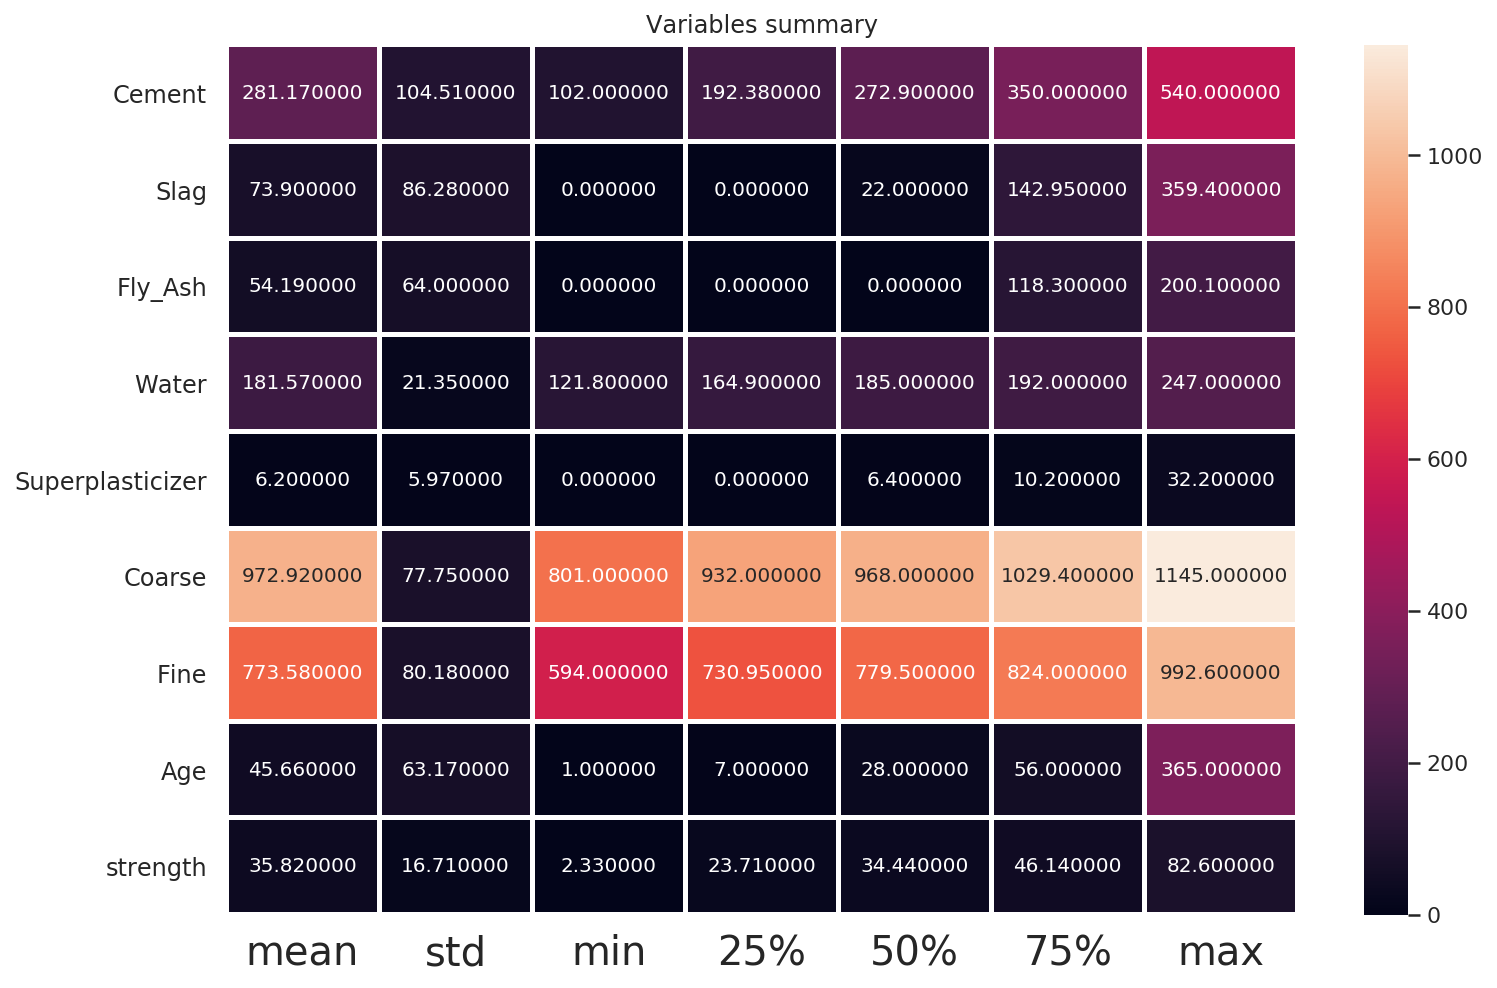

In [4]:


from mpl_toolkits.mplot3d import Axes3D
data1 = data.copy()
plt.figure(figsize=(12,8))
sns.heatmap(round(data.describe()[1:].transpose(),2),linewidth=2,annot=True,fmt="f")
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.title("Variables summary")
plt.show()



Some important things that we can observe, all the mixtures contain some amounts of water, cement and both kinds of the aggregates. That is what forms "basic" concrete. The other additions are either to improve strength (superplaticizer, slag) or to act as fillers to reduce cost (slag*, flyash). *Slag contributes to certain aspects of strength but also reduces the cost. 

Now lets just plot histograms and PMFs of the data to gain a more visual understanding.

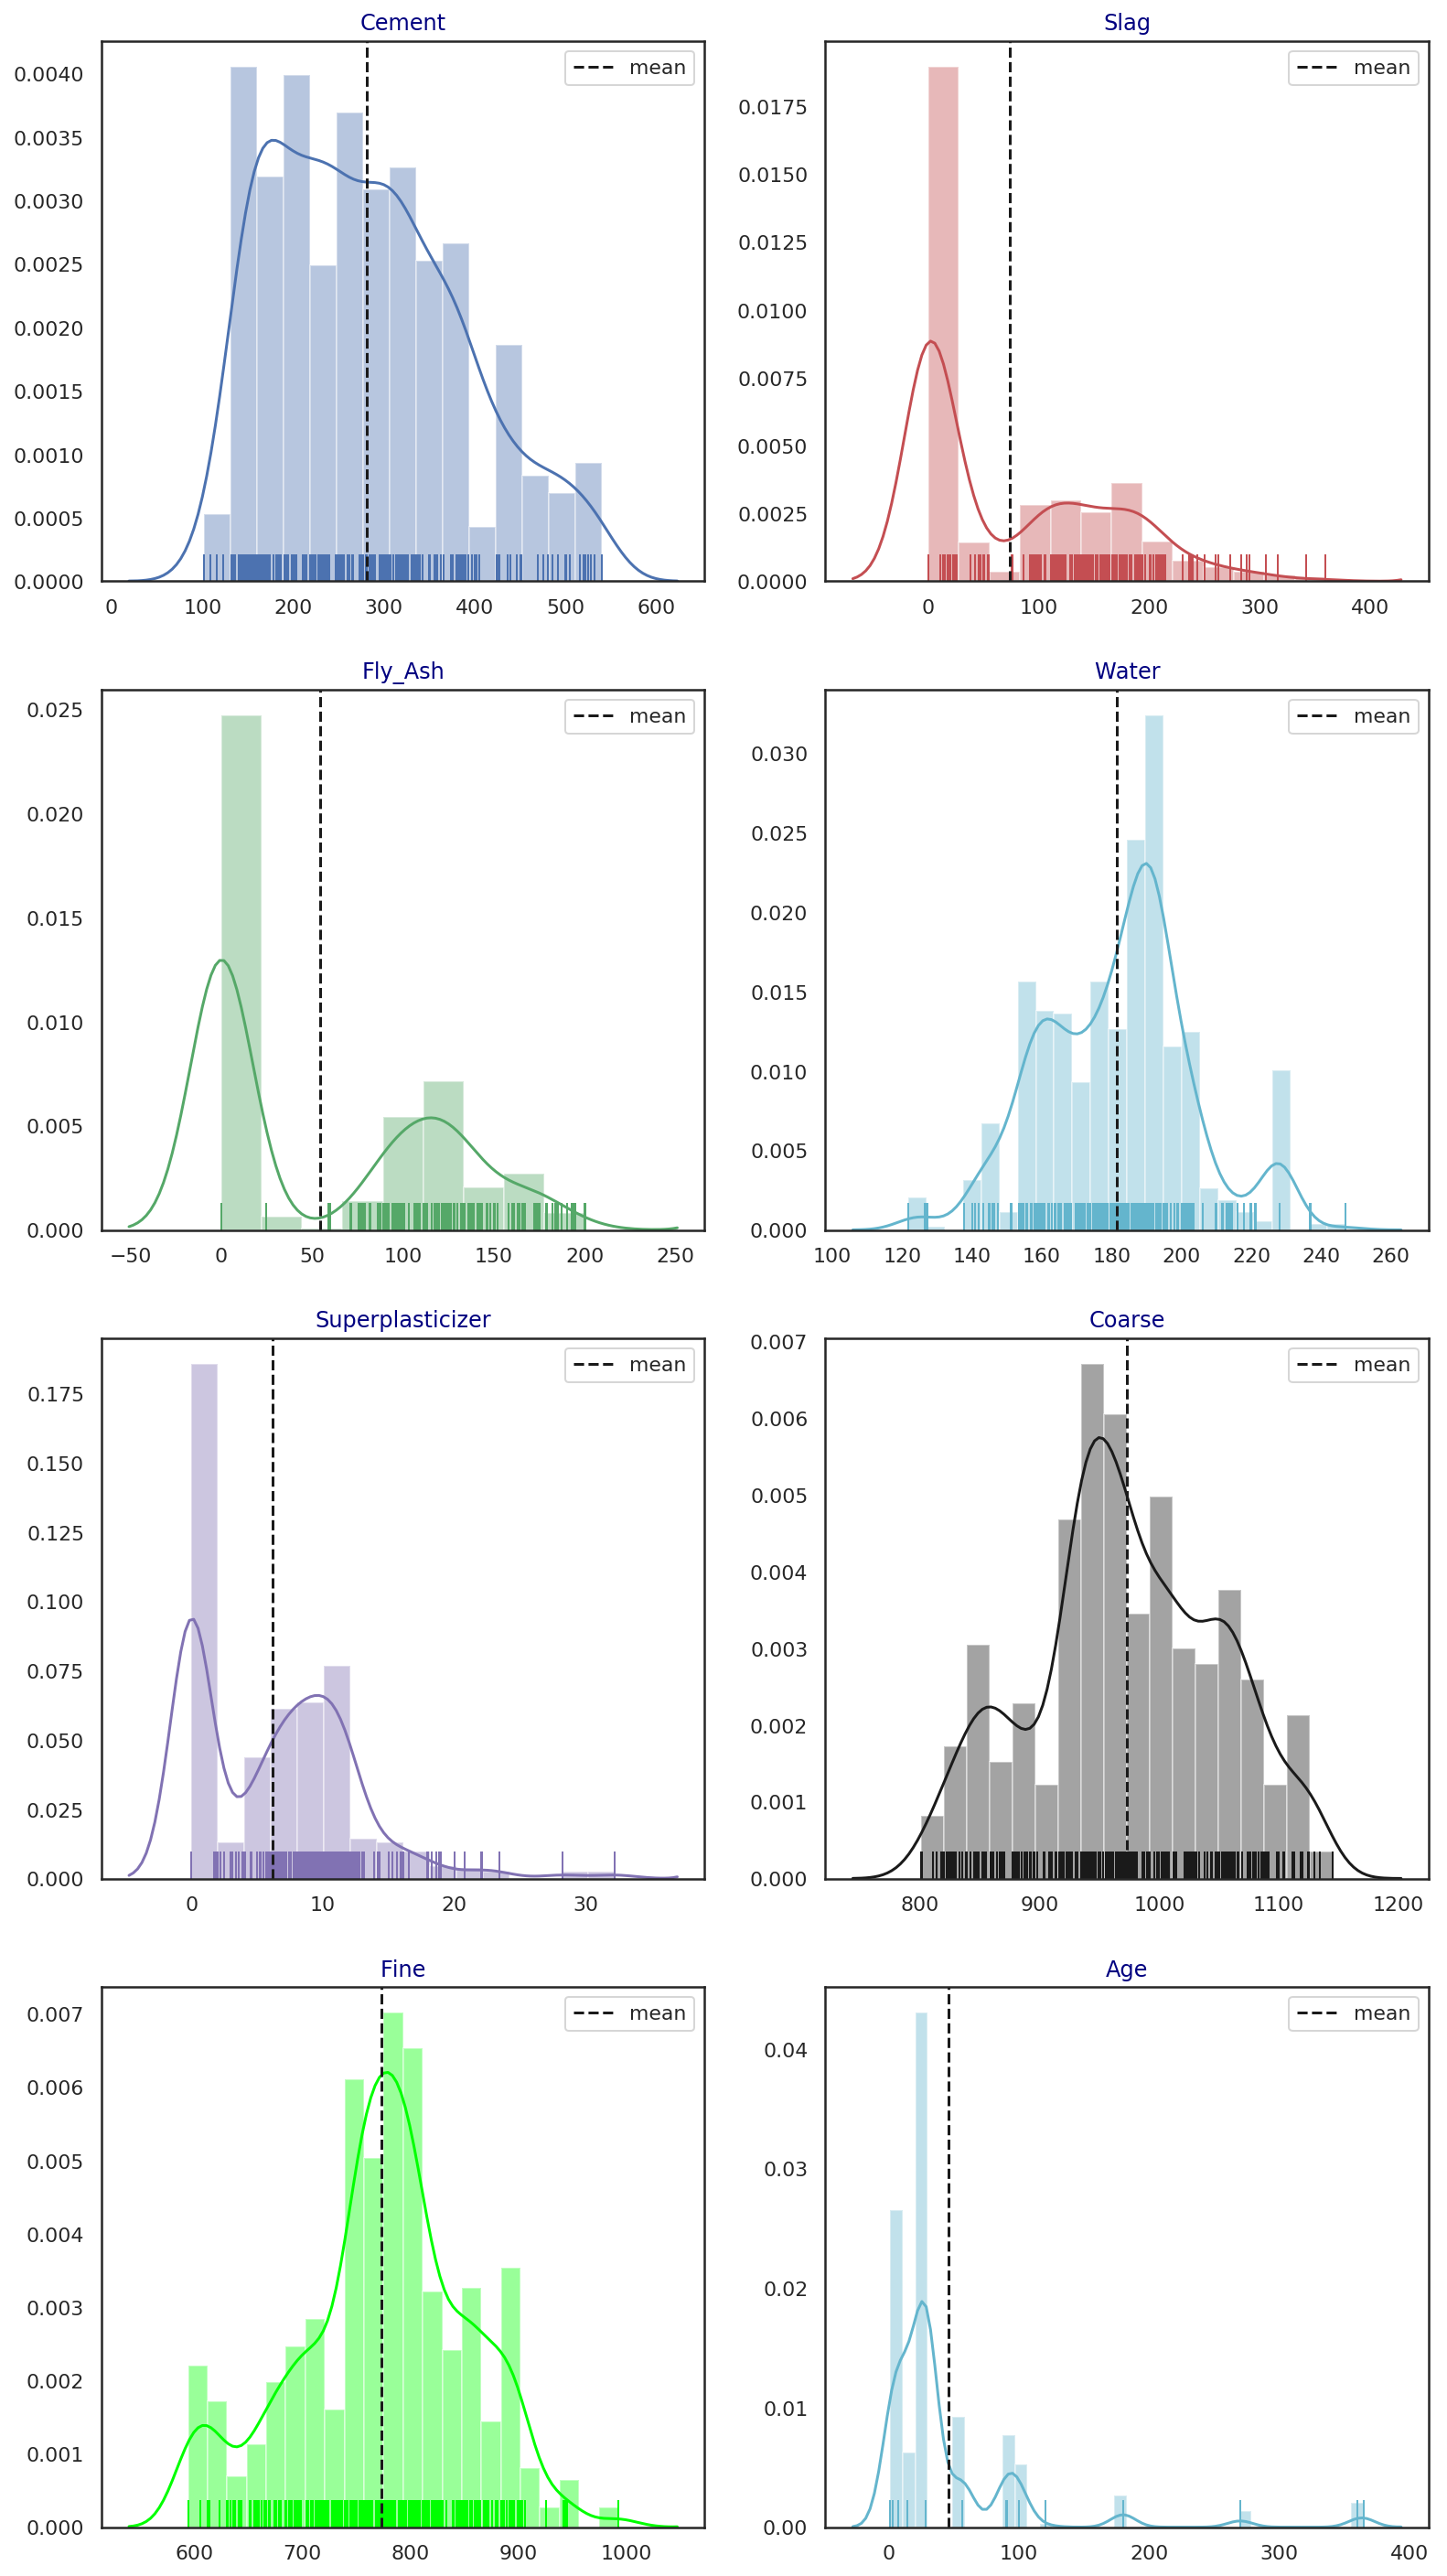

In [5]:
cols = [i for i in data.columns if i not in 'compressive_strength']
length = len(cols)
cs = ["b","r","g","c","m","k","lime","c"]
fig = plt.figure(figsize=(13,25))

for i,j,k in itertools.zip_longest(cols,range(length),cs):
    plt.subplot(4,2,j+1)
    ax = sns.distplot(data[i],color=k,rug=True)
    ax.set_facecolor("w")
    plt.axvline(data[i].mean(),linestyle="dashed",label="mean",color="k")
    plt.legend(loc="best")
    plt.title(i,color="navy")
    plt.xlabel("")

We can see that most of the mixes don't use the fillers (slag & flyash) and the superplasticizer and that most of the samples are tested below 50 days, which makes sense as most regulatory standards require strength to be measured on the 28th day.

Lets plot the compressive strength of cement along the amount of slag in the mixture. This shall allow us to identify any trends, if we find this useful we can extend this to the other variables. 

In [6]:

def plot_with_error(category,title):
    age2=df[(df['Age']<10)]
    age3=df[(df['Age']>10) & (df['Age']<30)];
    age4=df[(df['Age']>30) & (df['Age']<100)];
    age5=df[(df['Age']>100) & (df['Age']<250)];
    age6=df[(df['Age']>250)];
    fig, ax = subplots()
    grouped6=age6.groupby(category)
    grouped2=age2.groupby(category)
    grouped3=age3.groupby(category)
    grouped4=age4.groupby(category)
    grouped5=age5.groupby(category)
    series2=grouped2['strength'].mean()
    series3=grouped3['strength'].mean()
    series4=grouped4['strength'].mean()
    series5=grouped5['strength'].mean()
    series6=grouped6['strength'].mean()
    err2=grouped2['strength'].sem()
    err3=grouped3['strength'].sem()
    err4=grouped4['strength'].sem()
    err5=grouped5['strength'].sem()
    err6=grouped6['strength'].sem()
    series2.plot(color='C2',yerr=err2)
    series3.plot(color='C3',yerr=err3)
    series4.plot(color='C4',yerr=err4)
    series5.plot(color='C5',yerr=err4)
    series6.plot(color='C6',yerr=err5)
    ax.legend(["20-30", "30-40", "40-50","50-60","60+"])
    plt.title(title)


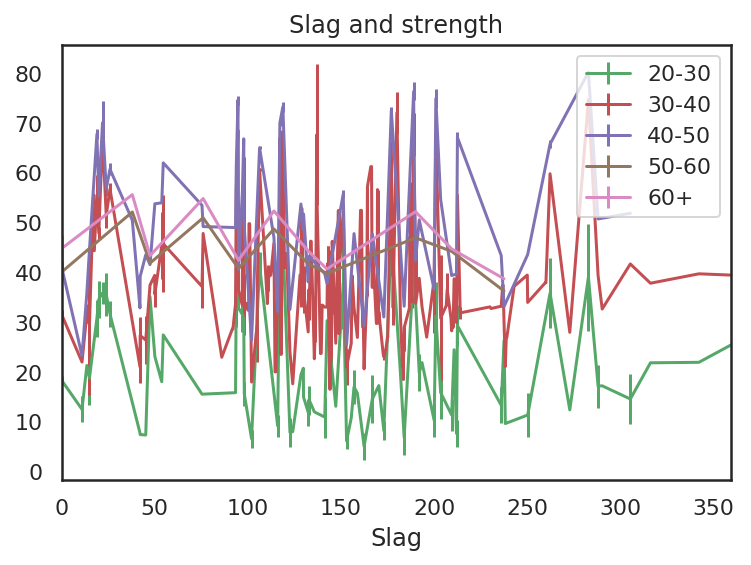

In [7]:
plot_with_error('Slag',"Slag and strength")

This plot seems like it does not contain any valuable information with all the noise and flat lines but it conveys something important about the dataset and concrete. It is not built as a test data set where different levels of slag are independently tested. Concrete is built to a specific strength and other variables are changed accordingly to achieve the same. The only variable which we can measure independently is the age of the pour as strength can be tested for the same mixture at different values of the variable. Thereby visualizing the strength of cement with various factors would not be very useful. We shall anyway use the Pairplot function to summarize these trends and generate a nice visual


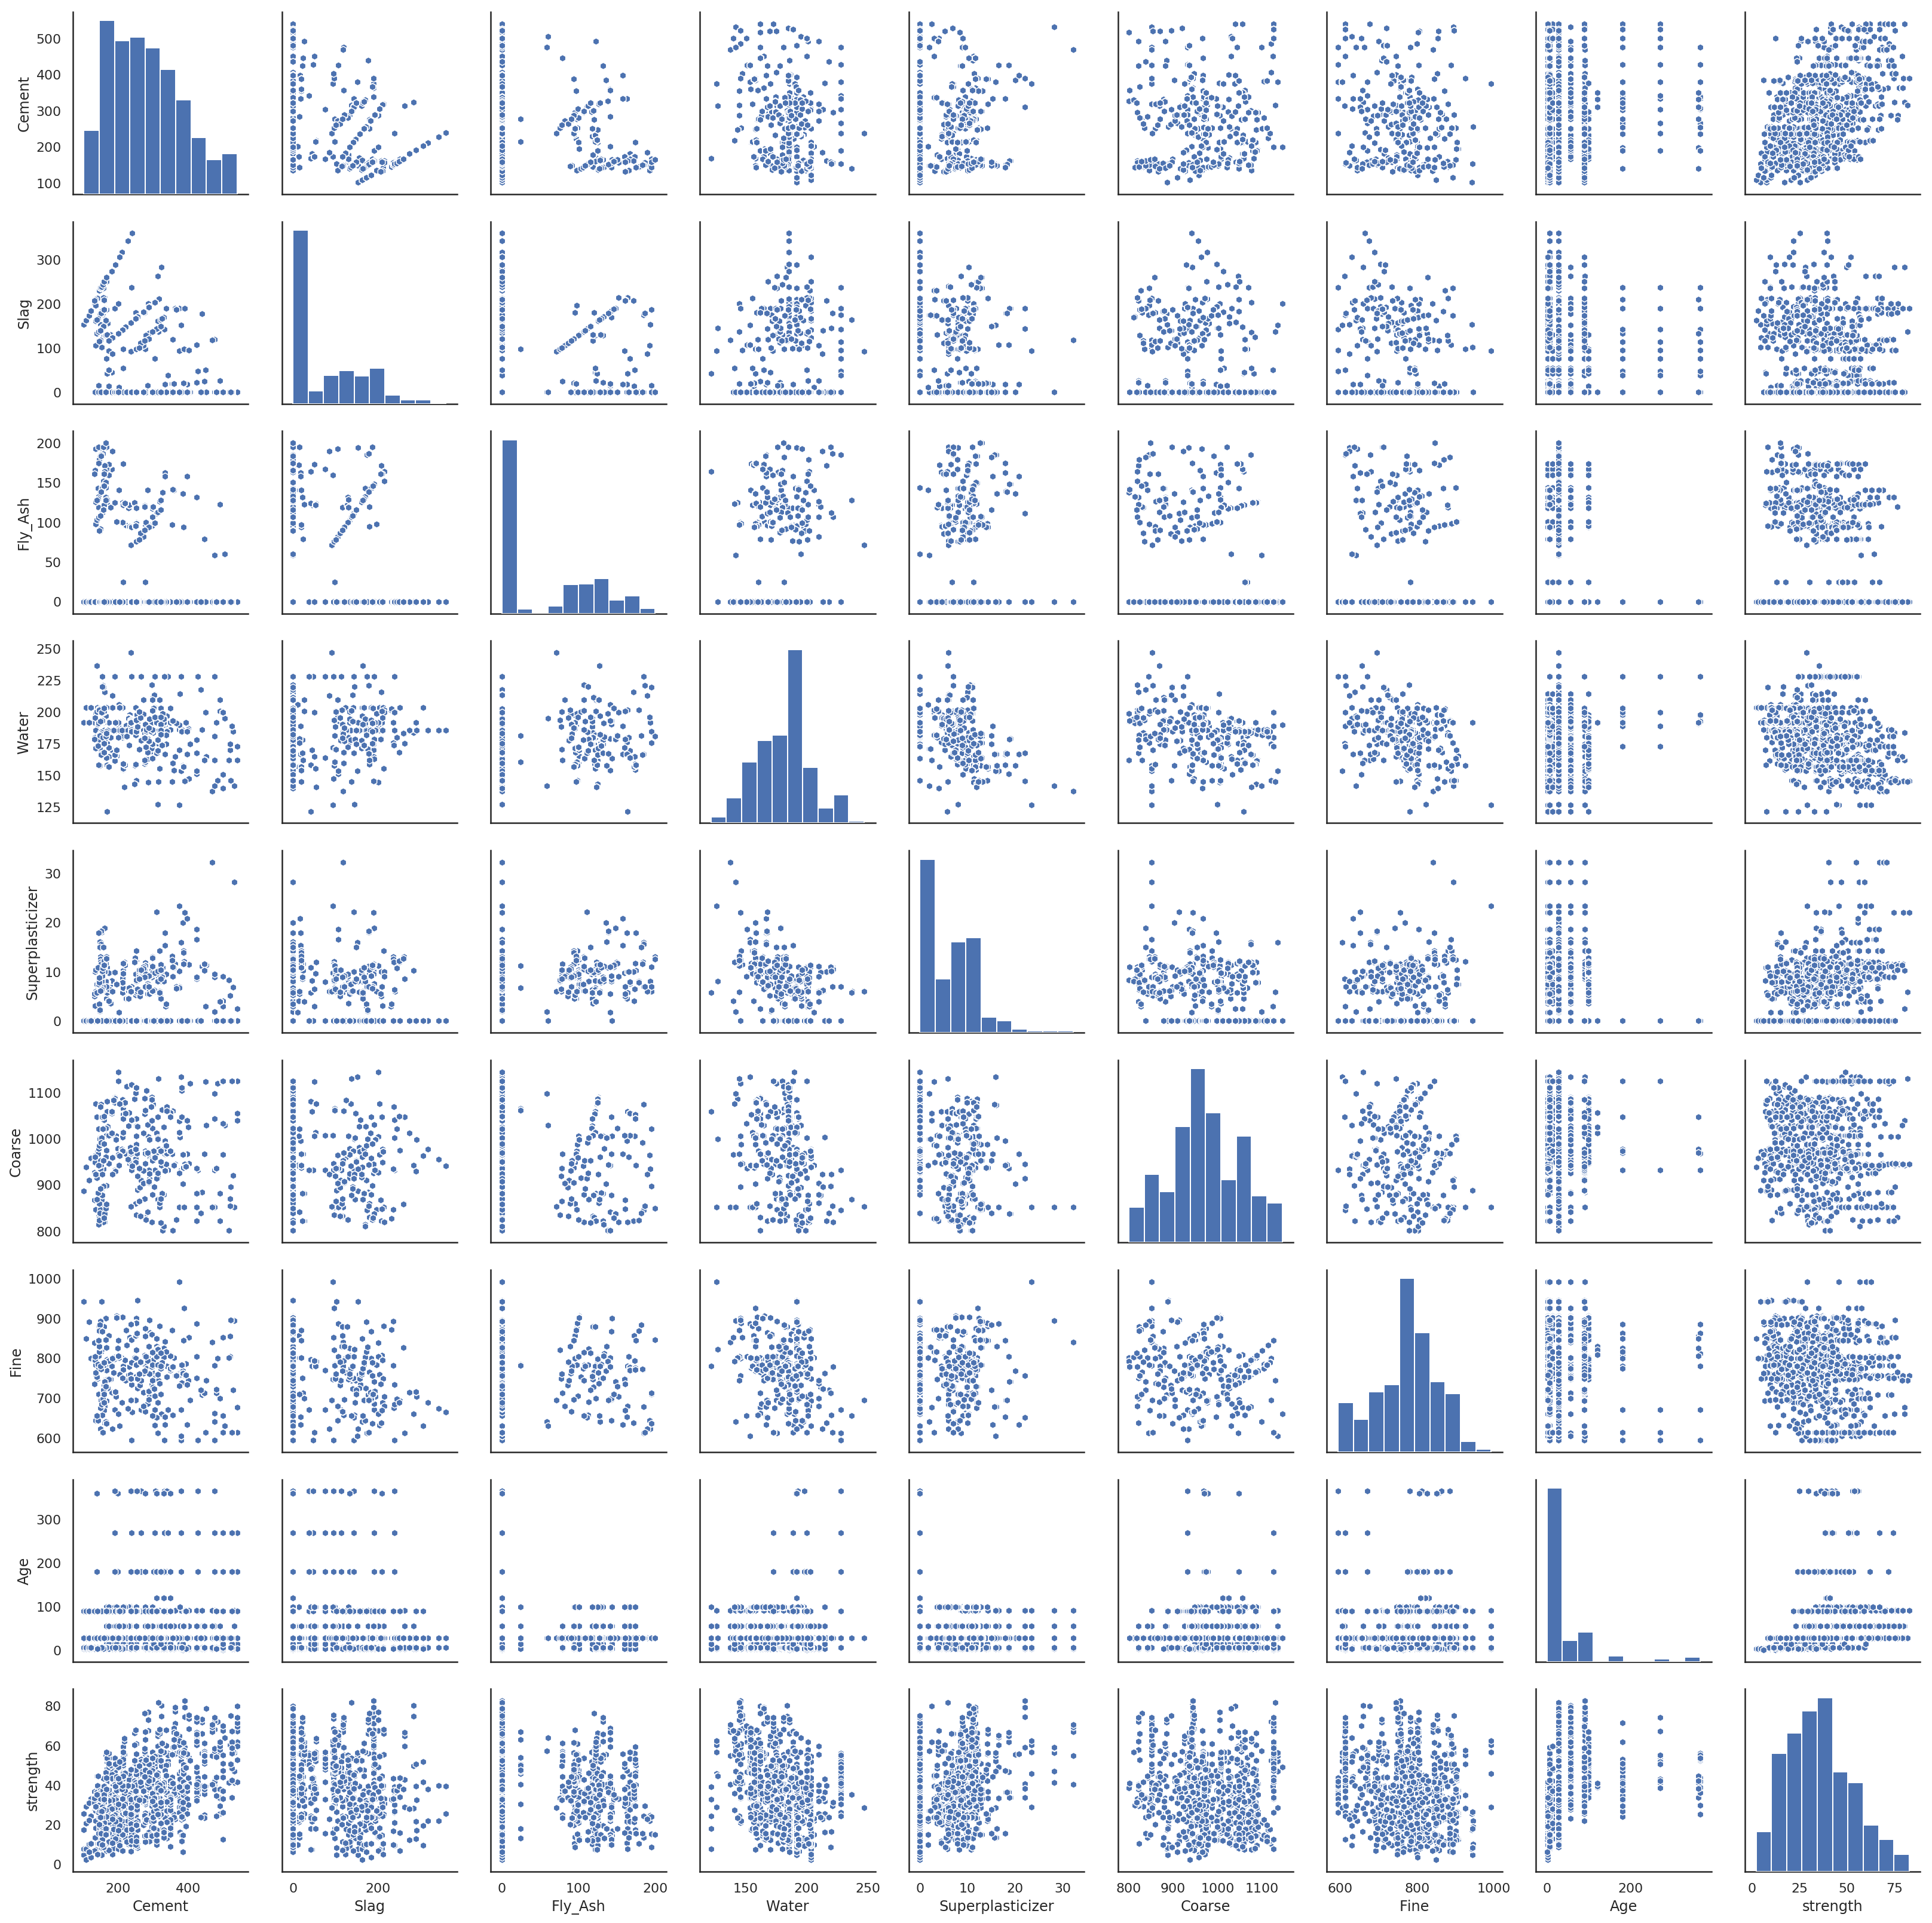

In [8]:
sns.pairplot(data,markers="h")
plt.show()



I am now going to plot contour plots between the various variables and the compressive strength to see if we can find any observations that might prove to be interesting.

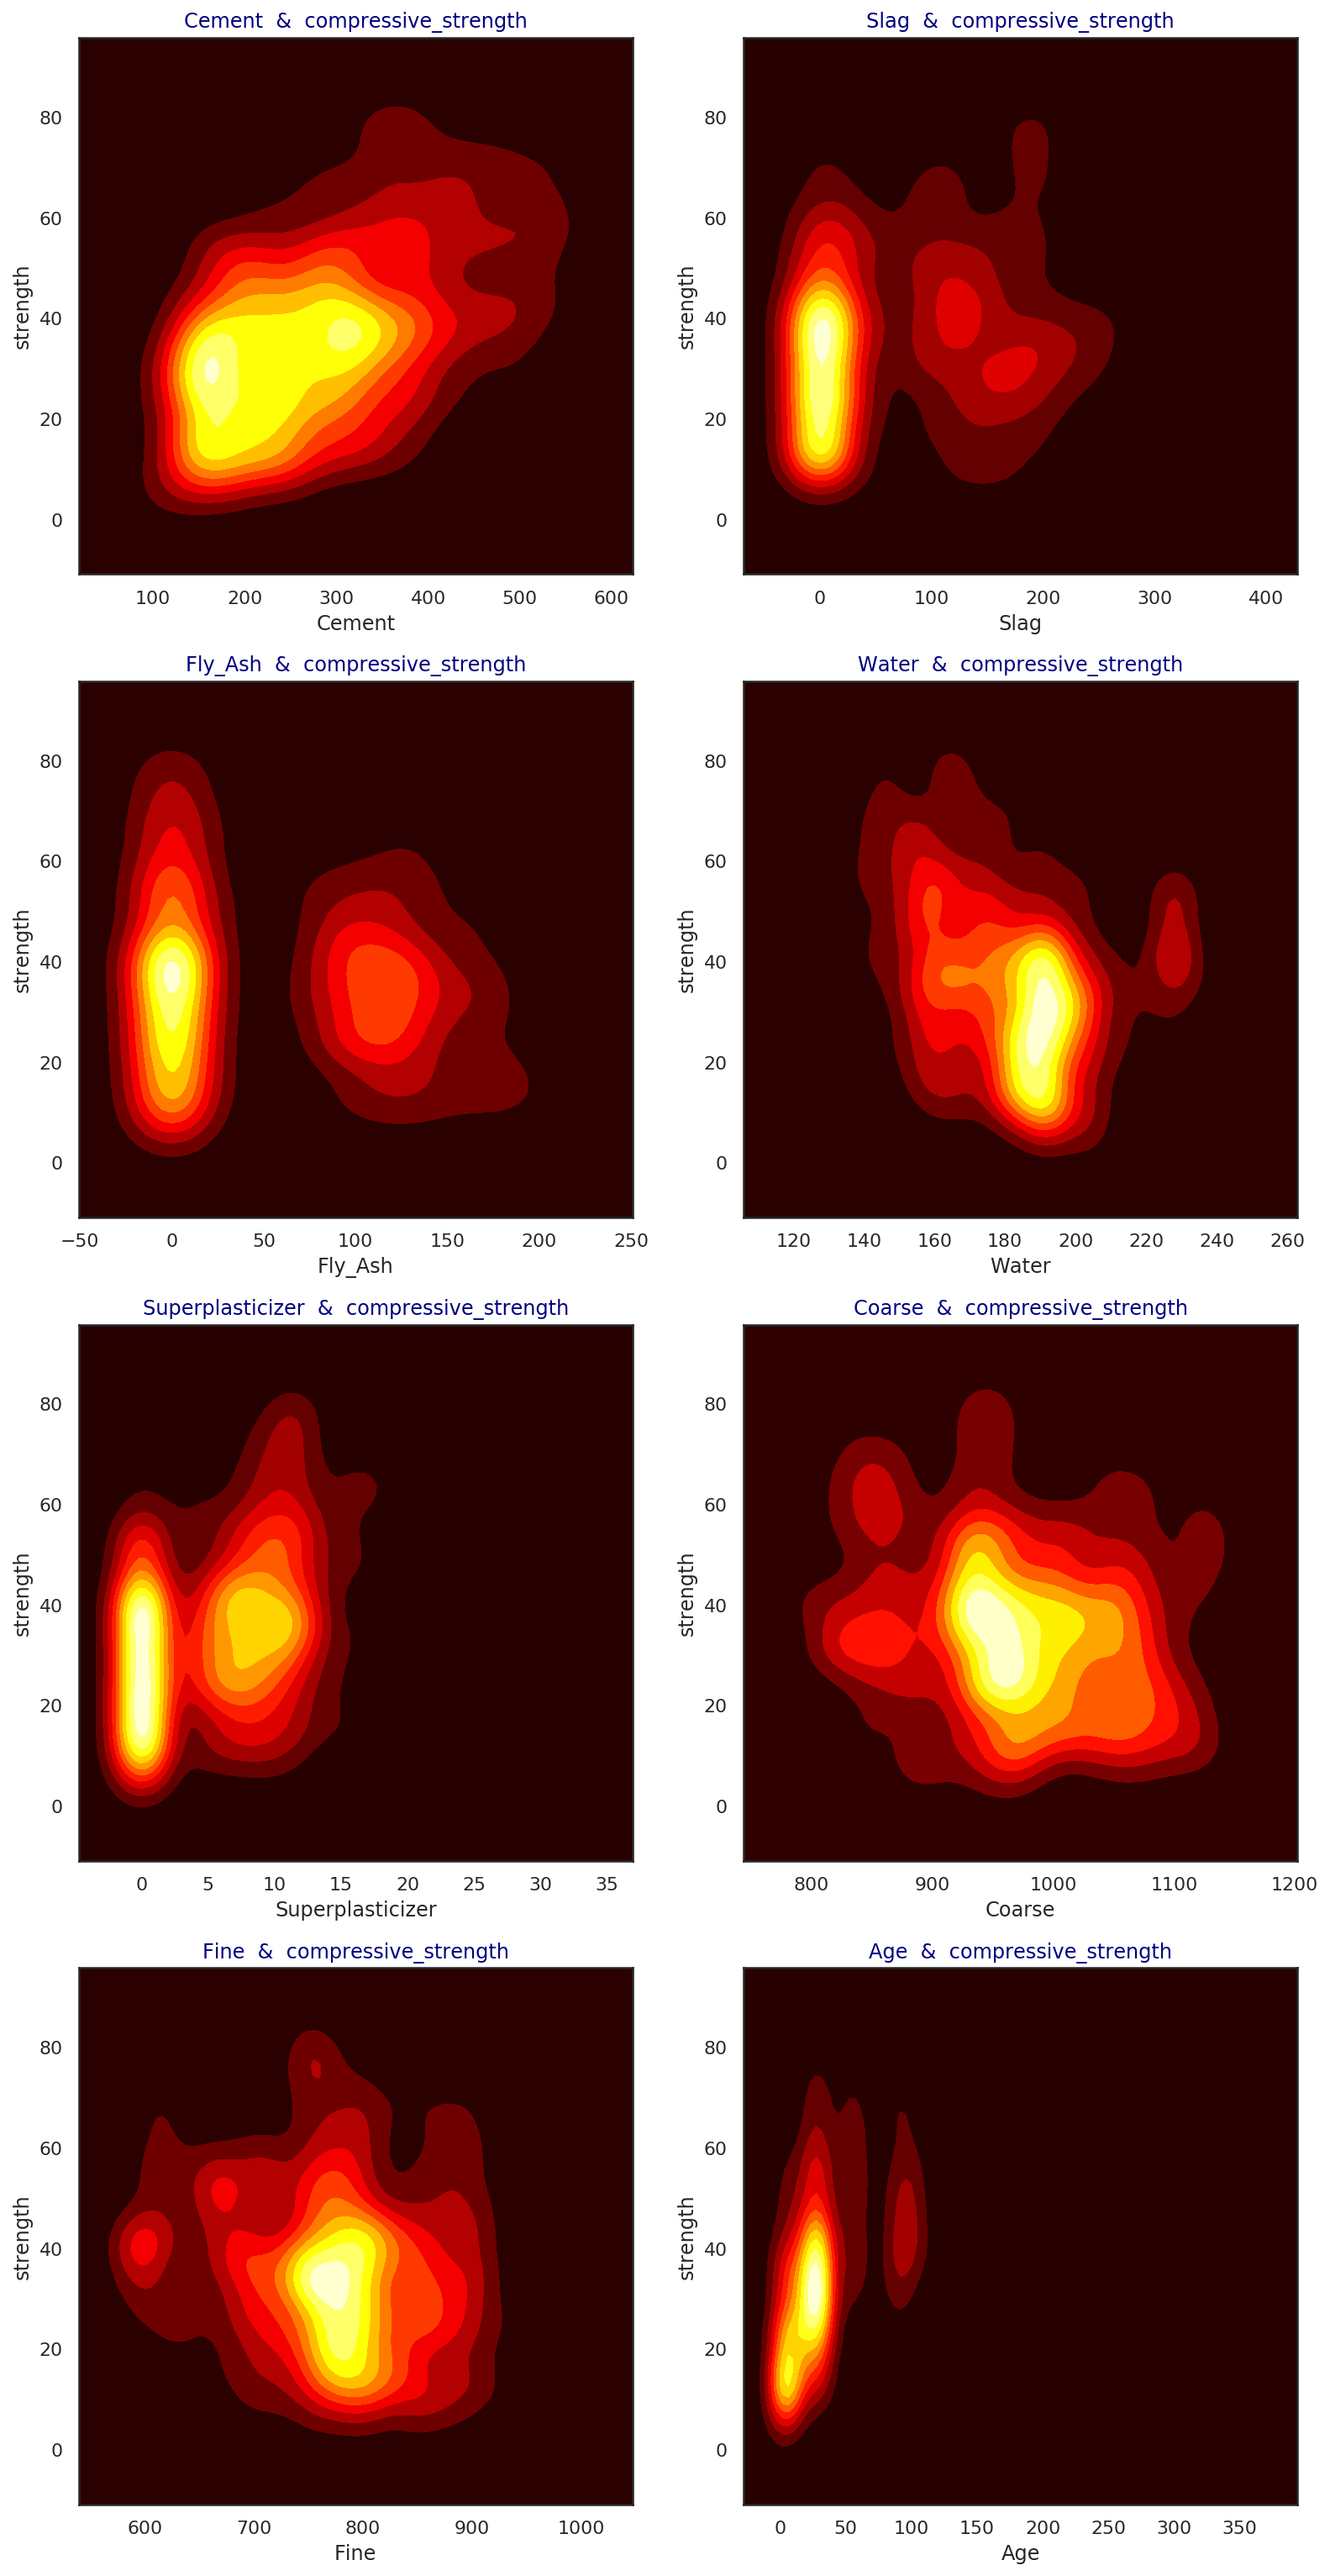

In [9]:
cols = [i for i in data.columns if i not in 'compressive_strength']
length = len(cols)

plt.figure(figsize=(13,27))
for i,j in itertools.zip_longest(cols,range(length)):
    plt.subplot(4,2,j+1)
    sns.kdeplot(data[i],
                data["strength"],
                cmap="hot",
                shade=True)
    plt.title(i+"  &  compressive_strength",color="navy")

Again this is not super useful but we see some observations like how the core ingredients (cement, water, coarse and fine) all have a pretty centered heat map covering a good amount of area with an "average" center.

Now lets look at how the different variables correlated with each other. It is a nice visual which shall help us understand which variables have the most influence.

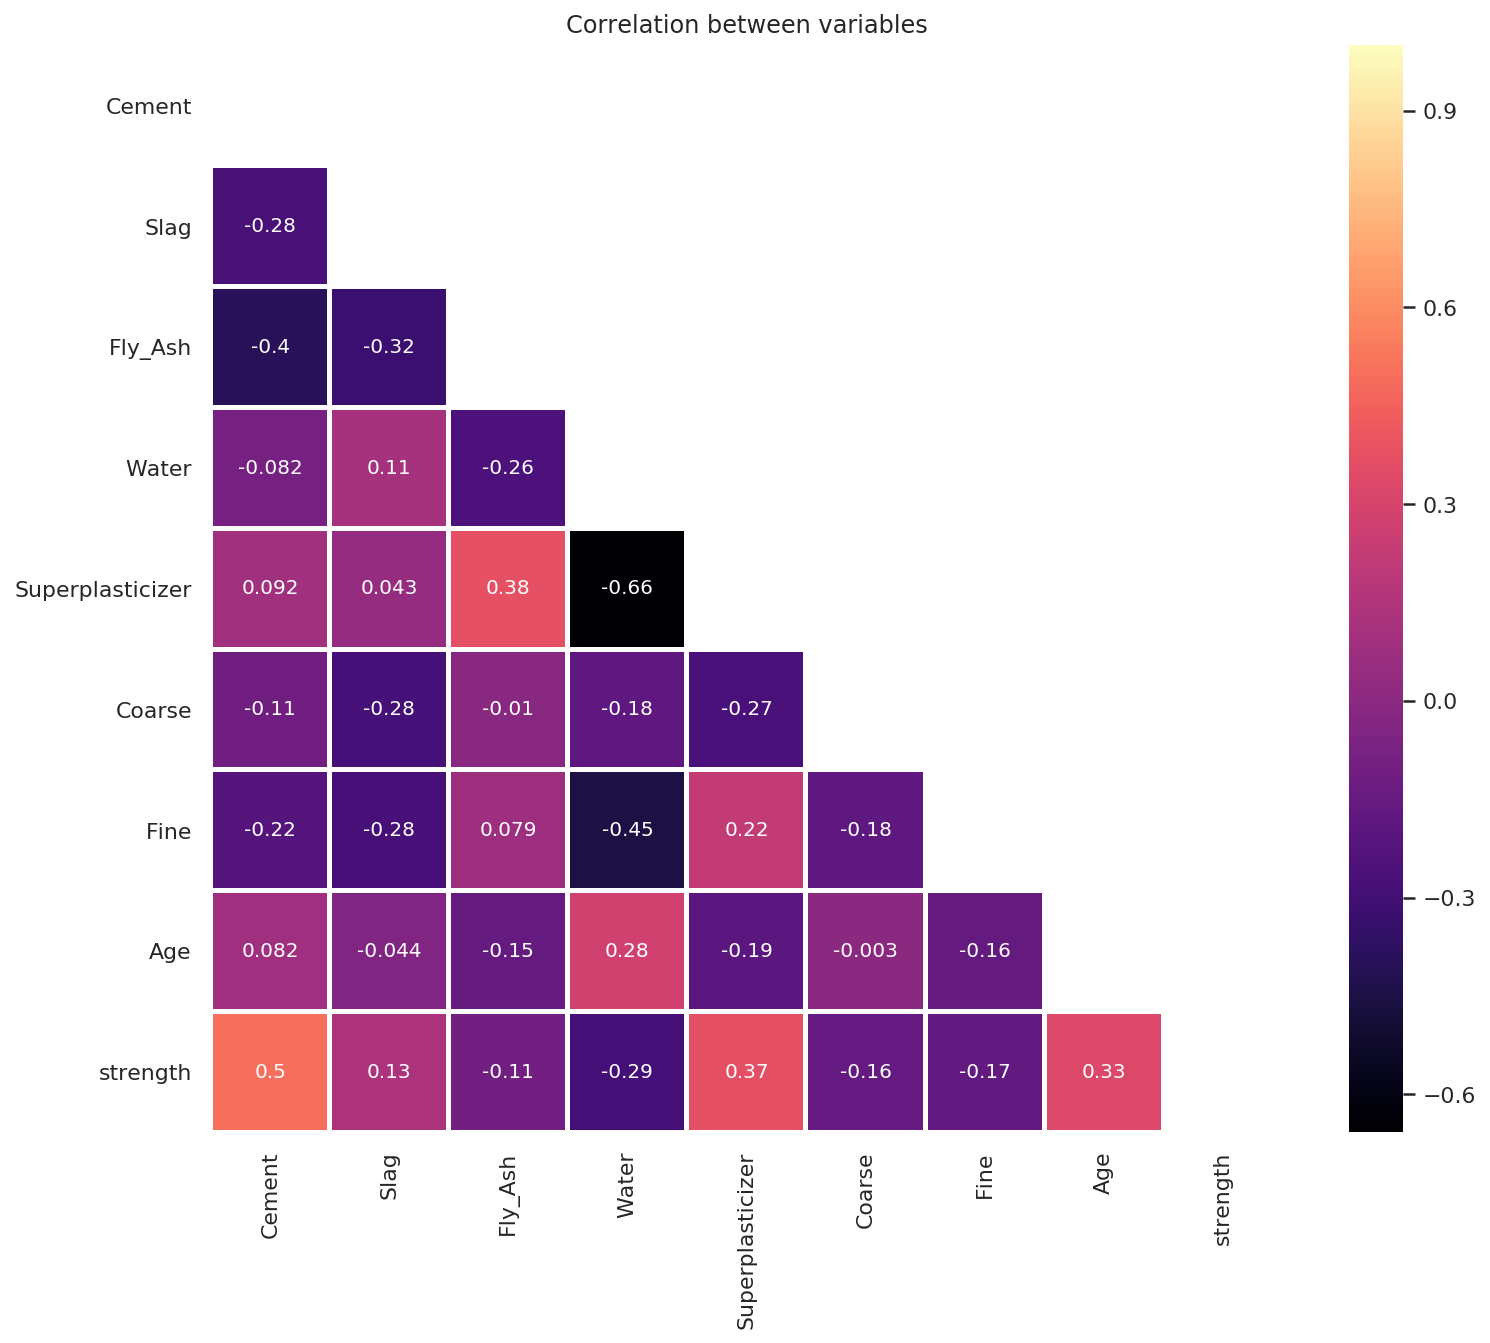

In [10]:
cor = data.corr()

mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,10))

with sns.axes_style("white"):
    sns.heatmap(cor,annot=True,linewidth=2,
                mask = mask,cmap="magma")
plt.title("Correlation between variables")
plt.show()


We see that strength is most greatly correlated with the amount of cement, amount of Superplasticizer and the age since pour. All of this follows common cement logic. Other interesting numbers include, the negative correlation between the quanitity of superplasticizer and the amount of the water. Superplasticizers increase the plasticity of the mixture and reduce the amount of water required. The amount of cement also correlates negatively with the amount of fillers(slag, fly ash) suggesting increased amounts of those would reduce costs. 

 #### Splitting dataset into train and test data.

Lets split the data set into training and testing sets so that we can evaluate the model later on.

In [11]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
len(train)


823

In [12]:
list(df)

['Cement',
 'Slag',
 'Fly_Ash',
 'Water',
 'Superplasticizer',
 'Coarse',
 'Fine',
 'Age',
 'strength']

In [13]:
X_train = train.iloc[:, :8]
y_train = train.iloc[:, 8:]
x_test= test.iloc[:,8:]
y_test = test.iloc[:,8:]

### Basic linear regression

We shall first  perform basic linear regression to see how the strength of the cement shall vary with the various variables. This may not prove very useful as most of the relationships except for age are highly non linear.

In [14]:

list(df)

['Cement',
 'Slag',
 'Fly_Ash',
 'Water',
 'Superplasticizer',
 'Coarse',
 'Fine',
 'Age',
 'strength']

We shall be using all the variables as we don't know yet which have the most influence. We shall use the square of Age as the link between age and the strength of cement is a standardized topic which is non-linear and most tests used to grade cement measure the strength at fixed number of days since casting.  

In [15]:
import statsmodels.formula.api as smf
model = smf.ols('strength ~  Slag +Cement + Fly_Ash+Water+Superplasticizer + Coarse +Fine+Age', data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strength   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     204.3
Date:                Sun, 12 May 2019   Prob (F-statistic):          6.29e-206
Time:                        18:26:15   Log-Likelihood:                -3869.0
No. Observations:                1030   AIC:                             7756.
Df Residuals:                    1021   BIC:                             7800.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -23.3312     26.586     -0.878      0.380     -75.500      28.837
Slag                 0.1039      0.010     10.247      0.000       0.084       0.124
Cement               0.1198      0.008     14.113      0.000       0.103       0.136
Fly_Ash              0.0879      0.013      6.988      0.000       0.063       0.113
Water               -0.1499      0.040     -3.731      0.000      -0.229      -0.071
Superplasticizer     0.2922      0.093      3.128      0.002       0.109       0.476
Coarse               0.0181      0.009      1.926      0.054      -0.000       0.037
Fine                 0.0202      0.011      1.887      0.059      -0.001       0.041
Age                  0.1142      0.005     21.046      0.000       0.104       0.125
==============================================================================
Omnibus:                        5.378   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                5.304
Skew:                          -0.174   Prob(JB):                       0.0705
Kurtosis:                       3.045   Cond. No.                     1.06e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

No handles with labels found to put in legend.


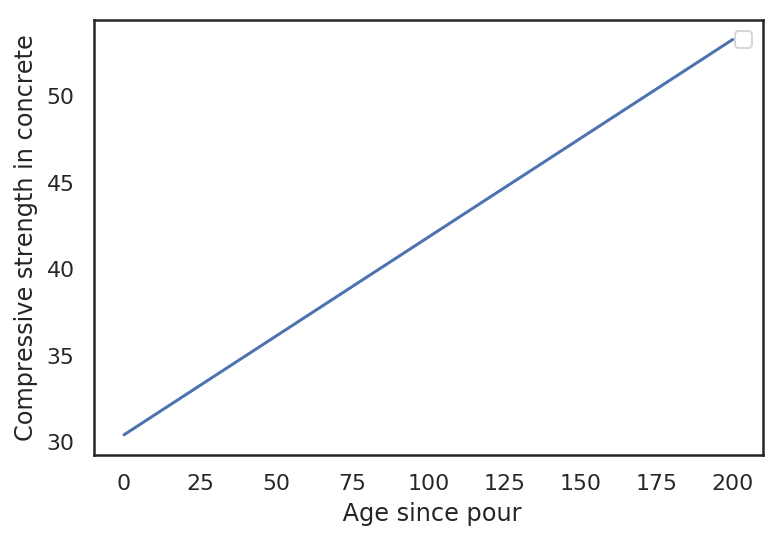

In [16]:

results = model.fit()
results.summary()
df2 = pd.DataFrame()
df2['Age'] = np.linspace(0, 200)
df2['Age2']=df2['Age']**2
df2['Fly_Ash']=55
df2['Water']=180
df2['Cement']=280

df2['Coarse'] = 970
df2['Fine']=780
df2['Superplasticizer']=6
df2['Slag']=70

results = model.fit()
pred12 = results.predict(df2)
plt.plot(df2['Age'], pred12)

plt.xlabel(' Age since pour')
plt.ylabel('Compressive strength in concrete')
plt.legend();

We can clearly see the positive link between the strength of concrete and the number of days since its pour. Concrete reacts with the water to cure with time. We can see that the largest gain in strength is in the inital stages. The gain in strength then levels off but still continues to grow for years. Cement strength is usually measured by most standards at 28 days since casting


### Neural Network.

Now lets build a neural network and fit it to our data. This seems useful to do as neural networks are great ways to explore non linear relationships between variables. 

Lets import all the required packages

In [20]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
#from xgboost import XGBRegressor

Lets build the Neural net. This is lifted from a template and is appropriate for a data set with < 20 numerical values and 1 numerical output.

In [21]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(256, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))


# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               2560      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 332,033
Trainable params: 332,033
Non-trainable params: 0
_________________________________________________________________


Lets set some checkpoints for the neural net. We shall be monitoring the loss value. We shall only saving the weight values where we see a decrease in report. The target variable is being set to the compressive strength of the concrete.


In [22]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
train_data = train
target = train_data['strength'] 

X = train.iloc[:, :8]
X['empty']=0
len(target)

823

Now lets fit the model to our data. We are running the thing for 200 epochs.

In [23]:
history= NN_model.fit(X, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 658 samples, validate on 165 samples
Epoch 1/500
658/658 [==============================] - 1s 2ms/step - loss: 17.3266 - mean_absolute_error: 17.3266 - val_loss: 10.4701 - val_mean_absolute_error: 10.4701

Epoch 00001: val_loss improved from inf to 10.47009, saving model to Weights-001--10.47009.hdf5
Epoch 2/500
658/658 [==============================] - 0s 532us/step - loss: 12.6661 - mean_absolute_error: 12.6661 - val_loss: 6.5133 - val_mean_absolute_error: 6.5133

Epoch 00002: val_loss improved from 10.47009 to 6.51329, saving model to Weights-002--6.51329.hdf5
Epoch 3/500
658/658 [==============================] - 0s 606us/step - loss: 10.9331 - mean_absolute_error: 10.9331 - val_loss: 7.2338 - val_mean_absolute_error: 7.2338

Epoch 00003: val_loss did not improve from 6.51329
Epoch 4/500
658/658 [==============================] - 0s 714us/step - loss: 9.7099 - mean_absolute_error: 9.7099 - val_loss: 8.4862 - val_mean_absolu

658/658 [==============================] - 1s 836us/step - loss: 4.7903 - mean_absolute_error: 4.7903 - val_loss: 8.7057 - val_mean_absolute_error: 8.7057

Epoch 00036: val_loss did not improve from 6.25150
Epoch 37/500
658/658 [==============================] - 0s 693us/step - loss: 5.3342 - mean_absolute_error: 5.3342 - val_loss: 12.6494 - val_mean_absolute_error: 12.6494

Epoch 00037: val_loss did not improve from 6.25150
Epoch 38/500
658/658 [==============================] - 0s 665us/step - loss: 4.8544 - mean_absolute_error: 4.8544 - val_loss: 7.2156 - val_mean_absolute_error: 7.2156

Epoch 00038: val_loss did not improve from 6.25150
Epoch 39/500
658/658 [==============================] - 0s 609us/step - loss: 4.5380 - mean_absolute_error: 4.5380 - val_loss: 7.3010 - val_mean_absolute_error: 7.3010

Epoch 00039: val_loss did not improve from 6.25150
Epoch 40/500
658/658 [==============================] - 0s 603us/step - loss: 4.6604 - mean_absolute_error: 4.6604 - val_loss: 9.89

658/658 [==============================] - 0s 485us/step - loss: 4.0142 - mean_absolute_error: 4.0142 - val_loss: 9.2961 - val_mean_absolute_error: 9.2961

Epoch 00073: val_loss did not improve from 6.25150
Epoch 74/500
658/658 [==============================] - 0s 301us/step - loss: 4.0665 - mean_absolute_error: 4.0665 - val_loss: 8.7772 - val_mean_absolute_error: 8.7772

Epoch 00074: val_loss did not improve from 6.25150
Epoch 75/500
658/658 [==============================] - 0s 475us/step - loss: 3.9026 - mean_absolute_error: 3.9026 - val_loss: 13.0211 - val_mean_absolute_error: 13.0211

Epoch 00075: val_loss did not improve from 6.25150
Epoch 76/500
658/658 [==============================] - 0s 616us/step - loss: 3.9912 - mean_absolute_error: 3.9912 - val_loss: 10.4359 - val_mean_absolute_error: 10.4359

Epoch 00076: val_loss did not improve from 6.25150
Epoch 77/500
658/658 [==============================] - 0s 479us/step - loss: 4.2688 - mean_absolute_error: 4.2688 - val_loss: 9.

658/658 [==============================] - 0s 460us/step - loss: 4.1304 - mean_absolute_error: 4.1304 - val_loss: 9.5748 - val_mean_absolute_error: 9.5748

Epoch 00110: val_loss did not improve from 6.25150
Epoch 111/500
658/658 [==============================] - 0s 501us/step - loss: 3.4345 - mean_absolute_error: 3.4345 - val_loss: 8.7287 - val_mean_absolute_error: 8.7287

Epoch 00111: val_loss did not improve from 6.25150
Epoch 112/500
658/658 [==============================] - 0s 471us/step - loss: 3.5715 - mean_absolute_error: 3.5715 - val_loss: 12.2886 - val_mean_absolute_error: 12.2886

Epoch 00112: val_loss did not improve from 6.25150
Epoch 113/500
658/658 [==============================] - 0s 530us/step - loss: 4.0503 - mean_absolute_error: 4.0503 - val_loss: 7.6357 - val_mean_absolute_error: 7.6357

Epoch 00113: val_loss did not improve from 6.25150
Epoch 114/500
658/658 [==============================] - 0s 375us/step - loss: 4.0196 - mean_absolute_error: 4.0196 - val_loss: 

658/658 [==============================] - 0s 571us/step - loss: 3.4264 - mean_absolute_error: 3.4264 - val_loss: 10.8951 - val_mean_absolute_error: 10.8951

Epoch 00147: val_loss did not improve from 6.25150
Epoch 148/500
658/658 [==============================] - 0s 560us/step - loss: 3.6696 - mean_absolute_error: 3.6696 - val_loss: 11.7272 - val_mean_absolute_error: 11.7272

Epoch 00148: val_loss did not improve from 6.25150
Epoch 149/500
658/658 [==============================] - 0s 708us/step - loss: 3.0295 - mean_absolute_error: 3.0295 - val_loss: 9.9405 - val_mean_absolute_error: 9.9405

Epoch 00149: val_loss did not improve from 6.25150
Epoch 150/500
658/658 [==============================] - 0s 580us/step - loss: 3.1798 - mean_absolute_error: 3.1798 - val_loss: 9.7945 - val_mean_absolute_error: 9.7945

Epoch 00150: val_loss did not improve from 6.25150
Epoch 151/500
658/658 [==============================] - 0s 581us/step - loss: 3.1644 - mean_absolute_error: 3.1644 - val_loss

658/658 [==============================] - 0s 656us/step - loss: 3.3339 - mean_absolute_error: 3.3339 - val_loss: 9.8382 - val_mean_absolute_error: 9.8382

Epoch 00184: val_loss did not improve from 6.25150
Epoch 185/500
658/658 [==============================] - 0s 623us/step - loss: 2.7887 - mean_absolute_error: 2.7887 - val_loss: 11.3627 - val_mean_absolute_error: 11.3627

Epoch 00185: val_loss did not improve from 6.25150
Epoch 186/500
658/658 [==============================] - 0s 545us/step - loss: 3.0883 - mean_absolute_error: 3.0883 - val_loss: 10.6525 - val_mean_absolute_error: 10.6525

Epoch 00186: val_loss did not improve from 6.25150
Epoch 187/500
658/658 [==============================] - 0s 382us/step - loss: 3.3111 - mean_absolute_error: 3.3111 - val_loss: 8.8352 - val_mean_absolute_error: 8.8352

Epoch 00187: val_loss did not improve from 6.25150
Epoch 188/500
658/658 [==============================] - 0s 529us/step - loss: 3.1117 - mean_absolute_error: 3.1117 - val_loss

658/658 [==============================] - 0s 427us/step - loss: 2.5418 - mean_absolute_error: 2.5418 - val_loss: 8.8353 - val_mean_absolute_error: 8.8353

Epoch 00221: val_loss did not improve from 6.25150
Epoch 222/500
658/658 [==============================] - 0s 711us/step - loss: 3.2473 - mean_absolute_error: 3.2473 - val_loss: 8.6534 - val_mean_absolute_error: 8.6534

Epoch 00222: val_loss did not improve from 6.25150
Epoch 223/500
658/658 [==============================] - 1s 846us/step - loss: 2.9397 - mean_absolute_error: 2.9397 - val_loss: 10.0436 - val_mean_absolute_error: 10.0436

Epoch 00223: val_loss did not improve from 6.25150
Epoch 224/500
658/658 [==============================] - 0s 544us/step - loss: 2.6356 - mean_absolute_error: 2.6356 - val_loss: 10.4087 - val_mean_absolute_error: 10.4087

Epoch 00224: val_loss did not improve from 6.25150
Epoch 225/500
658/658 [==============================] - 0s 405us/step - loss: 2.6458 - mean_absolute_error: 2.6458 - val_loss

658/658 [==============================] - 0s 369us/step - loss: 2.4323 - mean_absolute_error: 2.4323 - val_loss: 11.1745 - val_mean_absolute_error: 11.1745

Epoch 00258: val_loss did not improve from 6.25150
Epoch 259/500
658/658 [==============================] - 0s 375us/step - loss: 2.4022 - mean_absolute_error: 2.4022 - val_loss: 10.4722 - val_mean_absolute_error: 10.4722

Epoch 00259: val_loss did not improve from 6.25150
Epoch 260/500
658/658 [==============================] - 0s 498us/step - loss: 2.9394 - mean_absolute_error: 2.9394 - val_loss: 10.3338 - val_mean_absolute_error: 10.3338

Epoch 00260: val_loss did not improve from 6.25150
Epoch 261/500
658/658 [==============================] - 0s 477us/step - loss: 2.8022 - mean_absolute_error: 2.8022 - val_loss: 11.9352 - val_mean_absolute_error: 11.9352

Epoch 00261: val_loss did not improve from 6.25150
Epoch 262/500
658/658 [==============================] - 0s 373us/step - loss: 2.5327 - mean_absolute_error: 2.5327 - val_

658/658 [==============================] - 0s 402us/step - loss: 2.4556 - mean_absolute_error: 2.4556 - val_loss: 9.6224 - val_mean_absolute_error: 9.6224

Epoch 00295: val_loss did not improve from 6.25150
Epoch 296/500
658/658 [==============================] - 0s 433us/step - loss: 2.4188 - mean_absolute_error: 2.4188 - val_loss: 9.6542 - val_mean_absolute_error: 9.6542

Epoch 00296: val_loss did not improve from 6.25150
Epoch 297/500
658/658 [==============================] - 1s 770us/step - loss: 2.5719 - mean_absolute_error: 2.5719 - val_loss: 10.8878 - val_mean_absolute_error: 10.8878

Epoch 00297: val_loss did not improve from 6.25150
Epoch 298/500
658/658 [==============================] - 1s 939us/step - loss: 2.2520 - mean_absolute_error: 2.2520 - val_loss: 11.2418 - val_mean_absolute_error: 11.2418

Epoch 00298: val_loss did not improve from 6.25150
Epoch 299/500
658/658 [==============================] - 0s 548us/step - loss: 2.3725 - mean_absolute_error: 2.3725 - val_loss

658/658 [==============================] - 0s 472us/step - loss: 2.1839 - mean_absolute_error: 2.1839 - val_loss: 10.3053 - val_mean_absolute_error: 10.3053

Epoch 00332: val_loss did not improve from 6.25150
Epoch 333/500
658/658 [==============================] - 0s 544us/step - loss: 2.0810 - mean_absolute_error: 2.0810 - val_loss: 10.5097 - val_mean_absolute_error: 10.5097

Epoch 00333: val_loss did not improve from 6.25150
Epoch 334/500
658/658 [==============================] - 0s 730us/step - loss: 2.0968 - mean_absolute_error: 2.0968 - val_loss: 11.1871 - val_mean_absolute_error: 11.1871

Epoch 00334: val_loss did not improve from 6.25150
Epoch 335/500
658/658 [==============================] - 1s 1ms/step - loss: 2.4200 - mean_absolute_error: 2.4200 - val_loss: 9.6549 - val_mean_absolute_error: 9.6549

Epoch 00335: val_loss did not improve from 6.25150
Epoch 336/500
658/658 [==============================] - 1s 1ms/step - loss: 2.1878 - mean_absolute_error: 2.1878 - val_loss: 

658/658 [==============================] - 0s 722us/step - loss: 2.2659 - mean_absolute_error: 2.2659 - val_loss: 7.6740 - val_mean_absolute_error: 7.6740

Epoch 00369: val_loss did not improve from 6.25150
Epoch 370/500
658/658 [==============================] - 0s 637us/step - loss: 2.8187 - mean_absolute_error: 2.8187 - val_loss: 8.9609 - val_mean_absolute_error: 8.9609

Epoch 00370: val_loss did not improve from 6.25150
Epoch 371/500
658/658 [==============================] - 1s 882us/step - loss: 2.2945 - mean_absolute_error: 2.2945 - val_loss: 9.4176 - val_mean_absolute_error: 9.4176

Epoch 00371: val_loss did not improve from 6.25150
Epoch 372/500
658/658 [==============================] - 1s 819us/step - loss: 2.6657 - mean_absolute_error: 2.6657 - val_loss: 9.0712 - val_mean_absolute_error: 9.0712

Epoch 00372: val_loss did not improve from 6.25150
Epoch 373/500
658/658 [==============================] - 1s 912us/step - loss: 2.2223 - mean_absolute_error: 2.2223 - val_loss: 9.

658/658 [==============================] - 0s 473us/step - loss: 1.9211 - mean_absolute_error: 1.9211 - val_loss: 9.4398 - val_mean_absolute_error: 9.4398

Epoch 00406: val_loss did not improve from 6.25150
Epoch 407/500
658/658 [==============================] - 0s 688us/step - loss: 1.8547 - mean_absolute_error: 1.8547 - val_loss: 10.6209 - val_mean_absolute_error: 10.6209

Epoch 00407: val_loss did not improve from 6.25150
Epoch 408/500
658/658 [==============================] - 1s 803us/step - loss: 2.4675 - mean_absolute_error: 2.4675 - val_loss: 10.6264 - val_mean_absolute_error: 10.6264

Epoch 00408: val_loss did not improve from 6.25150
Epoch 409/500
658/658 [==============================] - 1s 899us/step - loss: 2.0084 - mean_absolute_error: 2.0084 - val_loss: 9.2950 - val_mean_absolute_error: 9.2950

Epoch 00409: val_loss did not improve from 6.25150
Epoch 410/500
658/658 [==============================] - 1s 1ms/step - loss: 2.0020 - mean_absolute_error: 2.0020 - val_loss: 

658/658 [==============================] - 0s 529us/step - loss: 2.1406 - mean_absolute_error: 2.1406 - val_loss: 9.7973 - val_mean_absolute_error: 9.7973

Epoch 00443: val_loss did not improve from 6.25150
Epoch 444/500
658/658 [==============================] - 0s 660us/step - loss: 2.4447 - mean_absolute_error: 2.4447 - val_loss: 9.5857 - val_mean_absolute_error: 9.5857

Epoch 00444: val_loss did not improve from 6.25150
Epoch 445/500
658/658 [==============================] - 0s 325us/step - loss: 2.1447 - mean_absolute_error: 2.1447 - val_loss: 9.0220 - val_mean_absolute_error: 9.0220

Epoch 00445: val_loss did not improve from 6.25150
Epoch 446/500
658/658 [==============================] - 0s 459us/step - loss: 2.0705 - mean_absolute_error: 2.0705 - val_loss: 10.0206 - val_mean_absolute_error: 10.0206

Epoch 00446: val_loss did not improve from 6.25150
Epoch 447/500
658/658 [==============================] - 0s 541us/step - loss: 1.7910 - mean_absolute_error: 1.7910 - val_loss: 

658/658 [==============================] - 0s 579us/step - loss: 2.1822 - mean_absolute_error: 2.1822 - val_loss: 10.8235 - val_mean_absolute_error: 10.8235

Epoch 00480: val_loss did not improve from 6.25150
Epoch 481/500
658/658 [==============================] - 0s 321us/step - loss: 1.9560 - mean_absolute_error: 1.9560 - val_loss: 9.6576 - val_mean_absolute_error: 9.6576

Epoch 00481: val_loss did not improve from 6.25150
Epoch 482/500
658/658 [==============================] - 0s 324us/step - loss: 1.9240 - mean_absolute_error: 1.9240 - val_loss: 10.0110 - val_mean_absolute_error: 10.0110

Epoch 00482: val_loss did not improve from 6.25150
Epoch 483/500
658/658 [==============================] - 0s 541us/step - loss: 2.1593 - mean_absolute_error: 2.1593 - val_loss: 9.5987 - val_mean_absolute_error: 9.5987

Epoch 00483: val_loss did not improve from 6.25150
Epoch 484/500
658/658 [==============================] - 0s 645us/step - loss: 1.8834 - mean_absolute_error: 1.8834 - val_loss

Now lets choose the weights file which was last saved. This was last done when we saw an improvement in loss. 

In [24]:
wights_file = 'Weights-052--6.58381.hdf5'

We shall now use those weights in our nueral net.

In [25]:
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

Now lets make predictions from our test data using the fitted model.

In [26]:

predictions = NN_model.predict(test)


Now lets plot the changes in the loss as the training took place

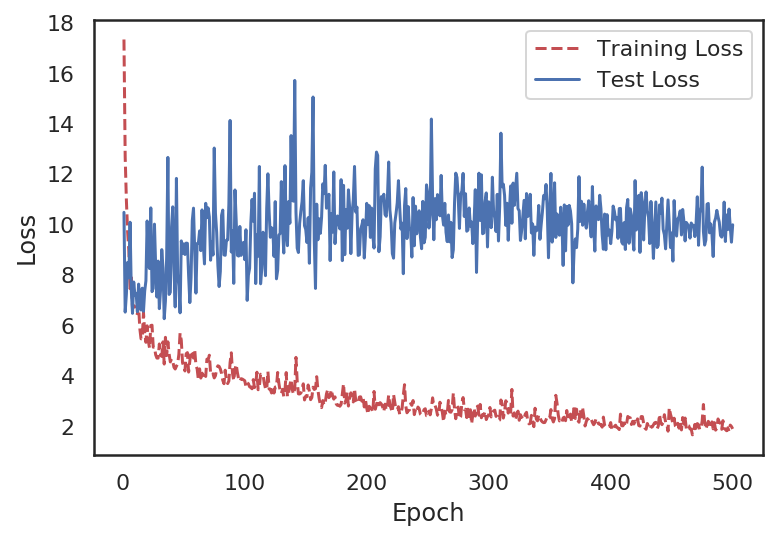

In [27]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Here we see that loss varys a lot but consistently keeps coming down.

The testing loss coming down with training loss staying constant may indicate overfitting.

In [28]:
test.iat[0,8]-predictions[0]

array([-3.1378365], dtype=float32)

Now lets plot how the strength of the conrete changes with the amount of cement in the mix.

No handles with labels found to put in legend.


Cement  Slag  Fly_Ash  Water  Superplasticizer  Coarse  Fine  Age  empty
0   0.000000   150       55    192                 0     970   825  360      0
1   8.163265   150       55    192                 0     970   825  360      0
2  16.326531   150       55    192                 0     970   825  360      0
3  24.489796   150       55    192                 0     970   825  360      0
4  32.653061   150       55    192                 0     970   825  360      0

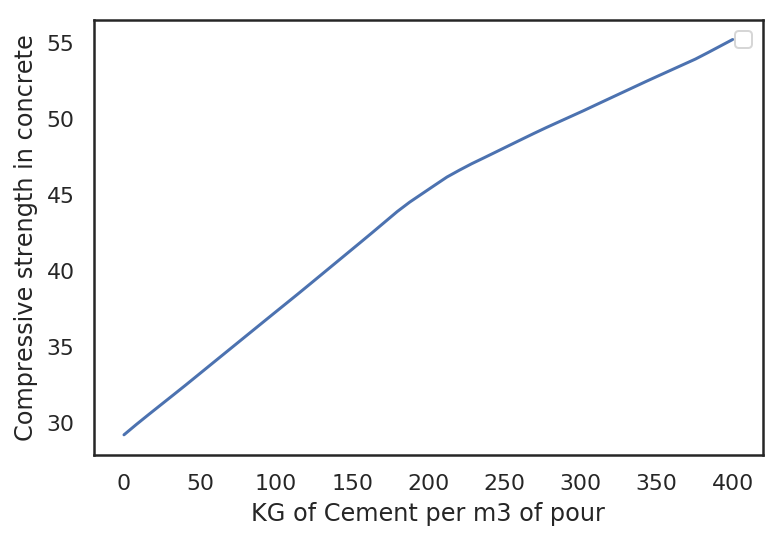

In [29]:

df2 = pd.DataFrame()

df2 = pd.DataFrame()
df2['Cement']=np.linspace(0, 400)
df2['Slag']=150
df2['Fly_Ash']=55
df2['Water']=192
df2['Superplasticizer']=0
df2['Coarse'] = 970
df2['Fine']=825
df2['Age'] = 360
df2['empty']=0;


predictions = NN_model.predict(df2)
plt.plot(df2['Cement'], predictions)

plt.xlabel('KG of Cement per m3 of pour')
plt.ylabel('Compressive strength in concrete')
plt.legend();
df2.head()

We see something that makes sense as the strength of the concrete would be expected to go up as the quantity of the main adhesive went up.

### Testing different machine learning options/models

Now lets use some of the regression methods we learnt in the datacamp course to make models and evaluate those. By testing various kinds of models we will be able to find which fits our data well and can give us the best results.

We shall be using this general function which shall fit the data to the algorithm, give us metrics, use the testing data to make predictions and then plot a graph using the model. It shall also rank the importance of the variables.


In [30]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
target = "compressive_strength"

def model(algorithm,dtrainx,dtrainy,dtestx,dtesty,testdf,test_results,of_type):
    
    print (algorithm)
    print ("***************************************************************************")
    algorithm.fit(dtrainx,dtrainy)
    prediction1 = algorithm.predict(testdf)
    prediction = algorithm.predict(dtestx)
    
    print ("ROOT MEAN SQUARED ERROR :", np.sqrt(mean_squared_error(dtesty,prediction)) )
    print ("***************************************************************************")
    prediction = pd.DataFrame(prediction)
    test_results=pd.DataFrame(prediction1)
    cross_val = cross_val_score(algorithm,dtrainx,dtrainy,cv=20,scoring="neg_mean_squared_error")
    cross_val = cross_val.ravel()
    print ("CROSS VALIDATION SCORE")
    print ("************************")
    print ("cv-mean :",cross_val.mean())
    print ("cv-std  :",cross_val.std())
    print ("cv-max  :",cross_val.max())
    print ("cv-min  :",cross_val.min())
    
    plt.figure(figsize=(13,28))
    plt.subplot(211)
    
    testy = dtesty.reset_index()["strength"]
    
    ax = testy.plot(label="originals",figsize=(12,13),linewidth=2)
    
    ax = prediction[0].plot(label = "predictions",figsize=(12,13),linewidth=2)
  #  plt.axhline(testy.mean(),color = "r",linestyle="dashed",label=("original_mean:",testy.mean()))
  #  plt.axhline(prediction[0].mean(),color="b",linestyle = "dashed",label=("prediction_mean:",prediction[0].mean()))
    plt.legend(loc="best")
    plt.title("ORIGINALS VS PREDICTIONS")
    plt.xlabel("index")
    plt.ylabel("values")
    ax.set_facecolor("k")
    ab=figure()
    plt.subplot(212)
   
    
    
    if of_type == "coef":
        coef = pd.DataFrame(algorithm.coef_.ravel())
        coef["feat"] = dtrainx.columns
        ax1 = sns.barplot(coef["feat"],coef[0],palette="jet_r",
                          linewidth=2,edgecolor="k"*coef["feat"].nunique())
        ax1.set_facecolor("lightgrey")
        ax1.axhline(0,color="k",linewidth=2)
        plt.ylabel("coefficients")
        plt.xlabel("features")
        plt.title('FEATURE IMPORTANCES')
    
    elif of_type == "feat":
        coef = pd.DataFrame(algorithm.feature_importances_)
        coef["feat"] = dtrainx.columns
        ax2 = sns.barplot(coef["feat"],coef[0],palette="jet_r",
                          linewidth=2,edgecolor="k"*coef["feat"].nunique())
        ax2.set_facecolor("lightgrey")
        ax2.axhline(0,color="k",linewidth=2)
        plt.ylabel("coefficients")
        plt.xlabel("features")
        plt.title('FEATURE IMPORTANCES')

    fig1, ax2 = plt.subplots()

    ax2.plot(df2['Cement'], test_results)
    
    plt.xlabel('KG of Cement per m3 of pour')
    plt.ylabel('Compressive strength in concrete')

import warnings
warnings.filterwarnings("ignore")

First we are going to run regular linear regression and see how it performs and then use it to predict how the strength of concrete varies with the amount of cement


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
***************************************************************************
ROOT MEAN SQUARED ERROR : 10.259026562177118
***************************************************************************
CROSS VALIDATION SCORE
************************
cv-mean : -113.26476202982501
cv-std  : 21.485876840663618
cv-max  : -67.5229596210266
cv-min  : -166.69393042000289


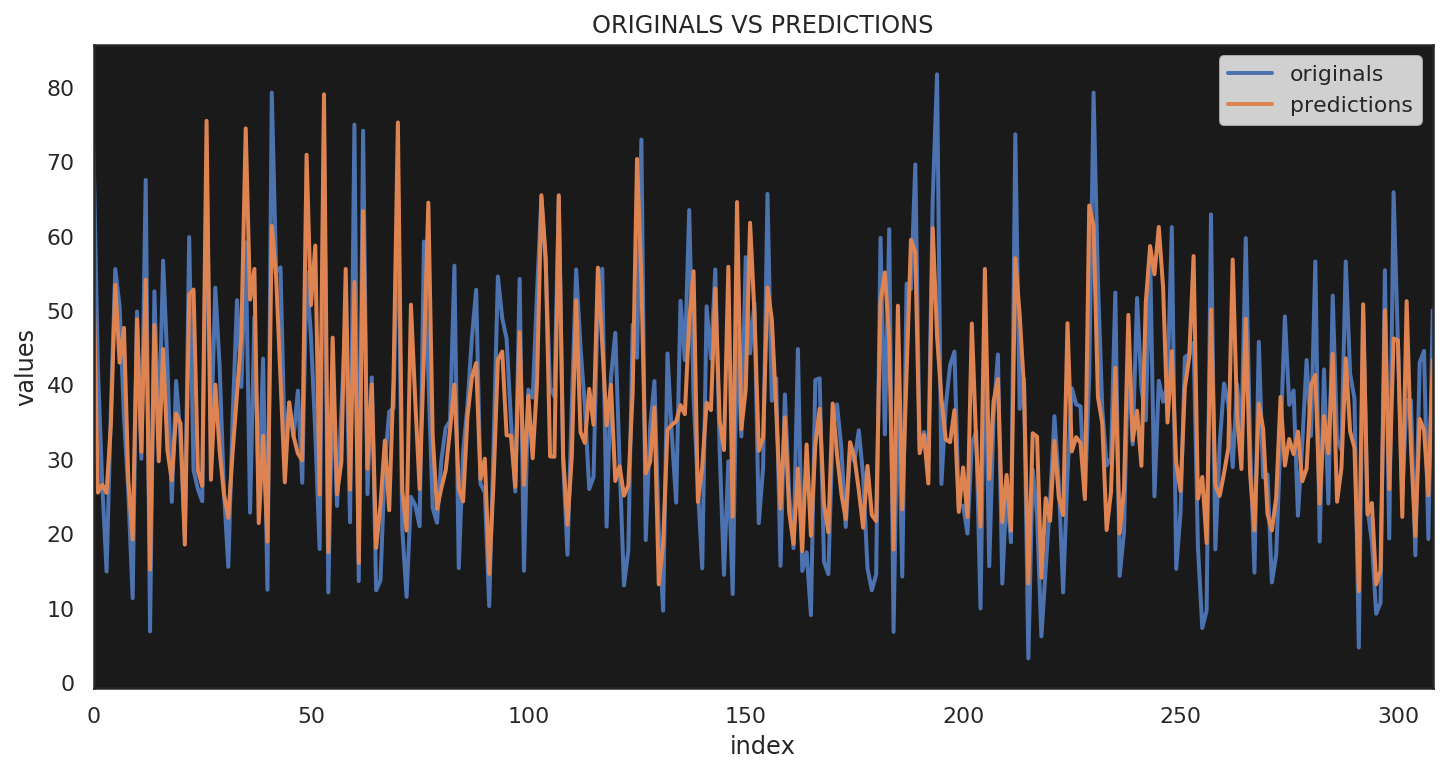

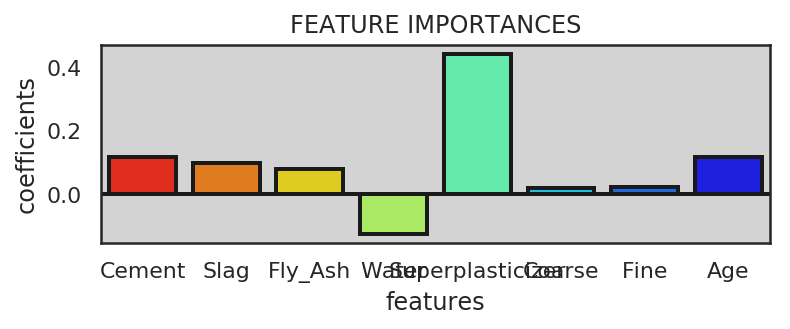

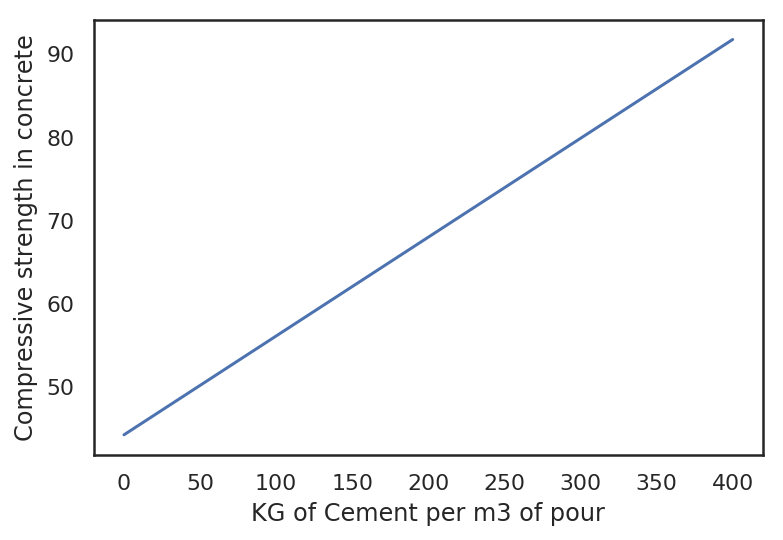

In [31]:

df2 = pd.DataFrame()
df2res=pd.DataFrame()
df2['Cement']=np.linspace(0, 400)
df2['Slag']=150
df2['Fly_Ash']=55
df2['Water']=192
df2['Superplasticizer']=0
df2['Coarse'] = 970
df2['Fine']=825
df2['Age'] = 360


#Splitting train and test data
from sklearn.model_selection import train_test_split

train,test = train_test_split(data,test_size =.3,random_state = 123)
train_X = train[[x for x in train.columns if x not in ["strength"] + ["age_months"]]]
train_Y = train["strength"]
test_X  = test[[x for x in test.columns if x not in ["strength"] + ["age_months"]]]
test_Y  = test["strength"]


from sklearn.linear_model import LinearRegression
lr = LinearRegression()
model(lr,train_X,train_Y,test_X,test_Y,df2,df2res,"coef")



If we look at the comparison between the actual and plotted values, we see that the model is on the right track with the predictions being close to the actual results.

We see that the model considers the amount of superplaticizer used as the most important factor.

Looking at the variation of strength with the amount of cement, this also follows the general theory that more cement equals greater compressive strengths.

Now lets use Lasso regression. This does linear regression coupled with regularization of the parameters.




Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
***************************************************************************
ROOT MEAN SQUARED ERROR : 10.222289461079958
***************************************************************************
CROSS VALIDATION SCORE
************************
cv-mean : -113.33064732894589
cv-std  : 21.135184436354397
cv-max  : -67.93694309398683
cv-min  : -164.92280242787803


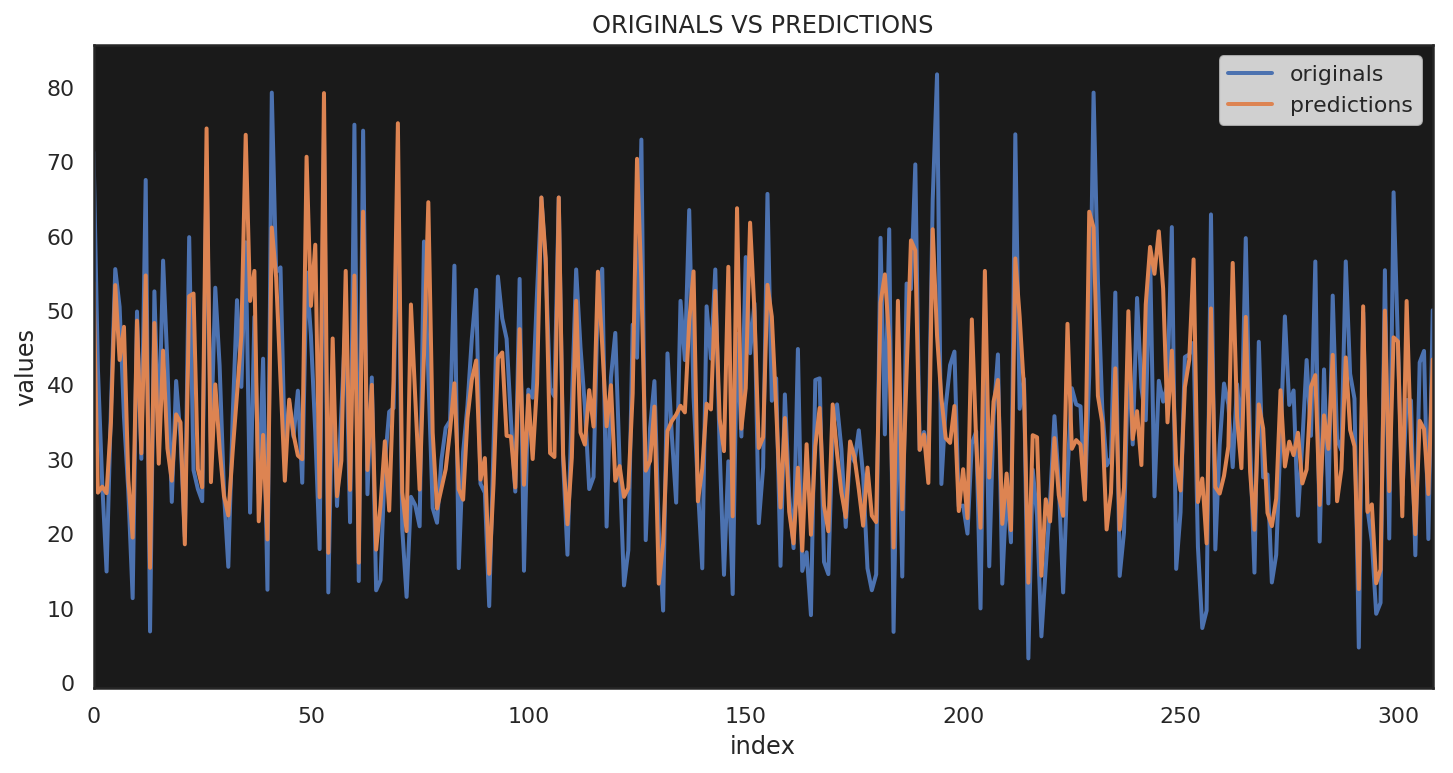

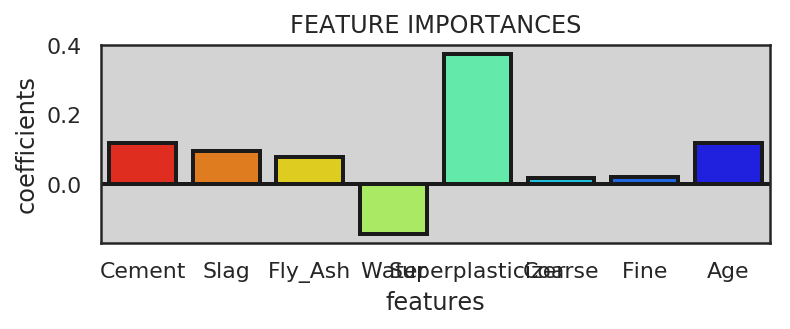

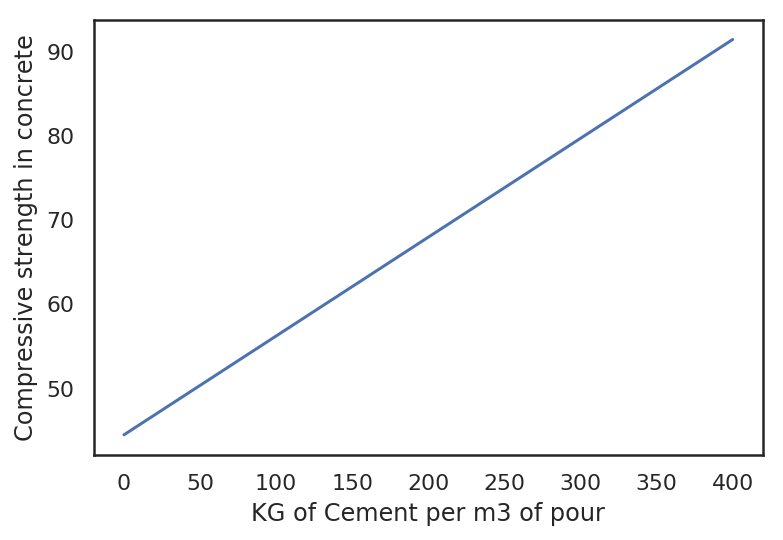

In [32]:
from sklearn.linear_model import Ridge,Lasso
ls = Lasso()
model(ls,train_X,train_Y,test_X,test_Y,df2,df2res,"coef")


We see very similar CV scores and results. The feature identified as the most important also stays the same. This indicates that regularization might not have been much help. 

I shall now use Ridge regression and see if that method helps.

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
***************************************************************************
ROOT MEAN SQUARED ERROR : 10.258998220231287
***************************************************************************
CROSS VALIDATION SCORE
************************
cv-mean : -113.26468230948262
cv-std  : 21.48565085432168
cv-max  : -67.52314595848341
cv-min  : -166.69259552822317


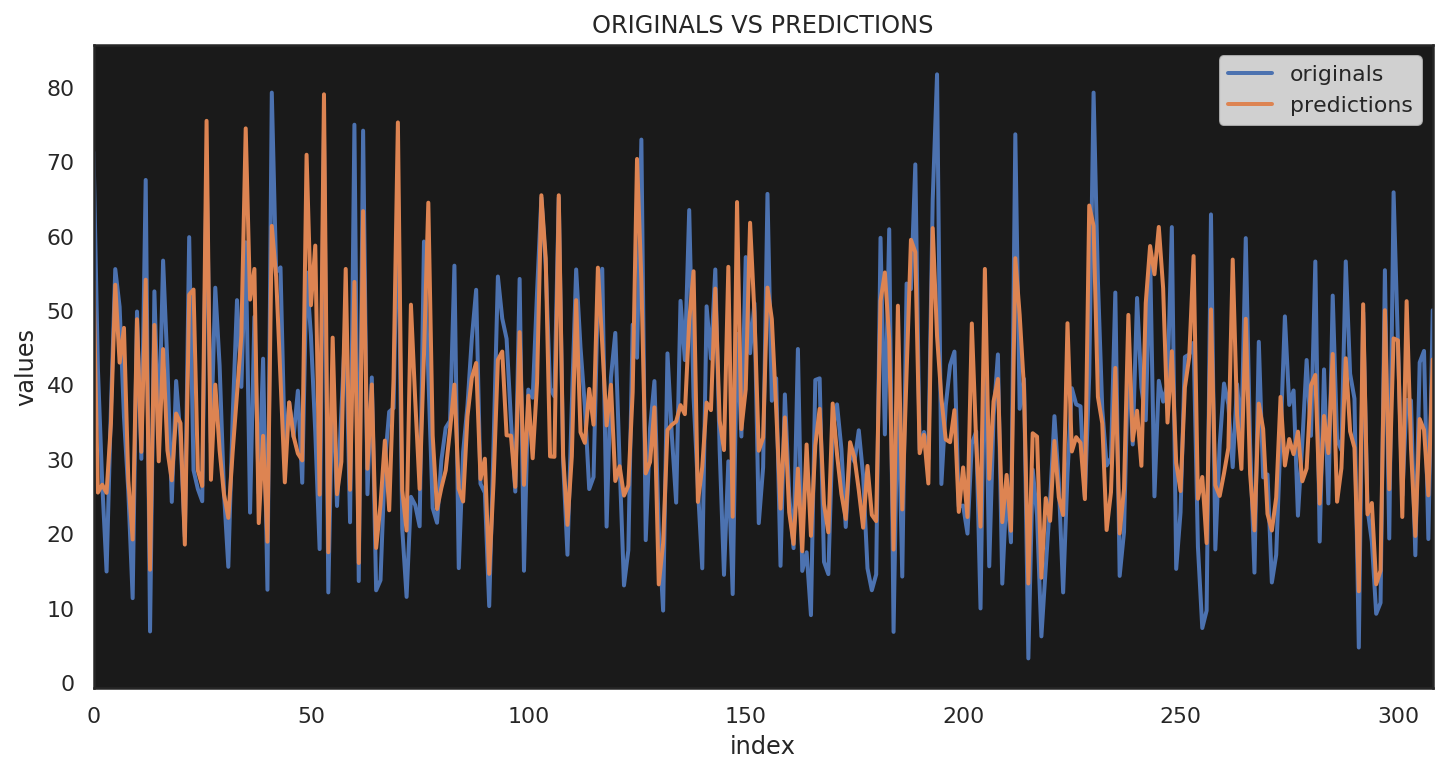

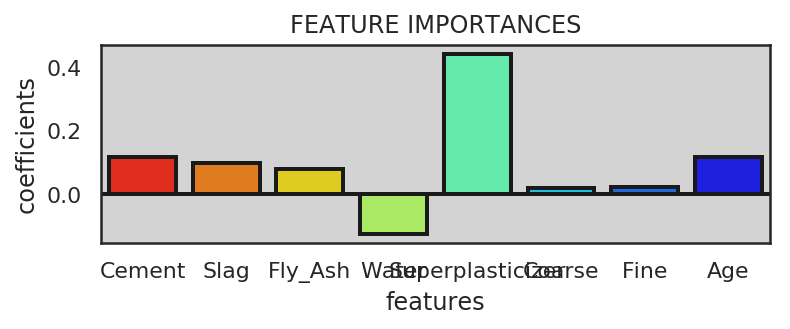

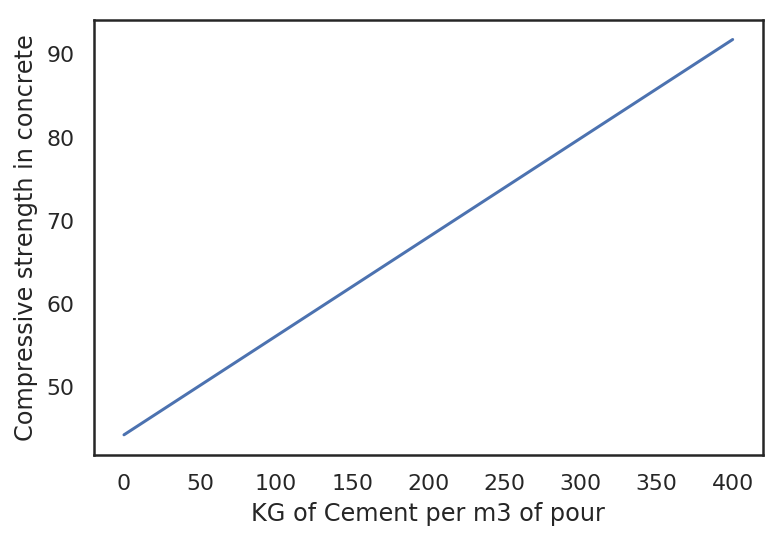

In [33]:


rigde = Ridge()
model(rigde,train_X,train_Y,test_X,test_Y,df2,df2res,"coef")



We see very similar CV scores and results. The feature identified as the most important also stays the same. This indicates that the change in the kind of regularization might not have been much help.

Now let's try a different type of model, K Nearest Neighbours and look at its results.


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')
************************************************************************
ROOT MEAN SQUARED ERROR :  8.368062025239324
************************************************************************
CROSS VALIDATION SCORE
************************
cv-mean : -94.18435302297297
cv-std  : 24.67626497553364
cv-max  : -53.25858833333333
cv-min  : -148.8523550000001


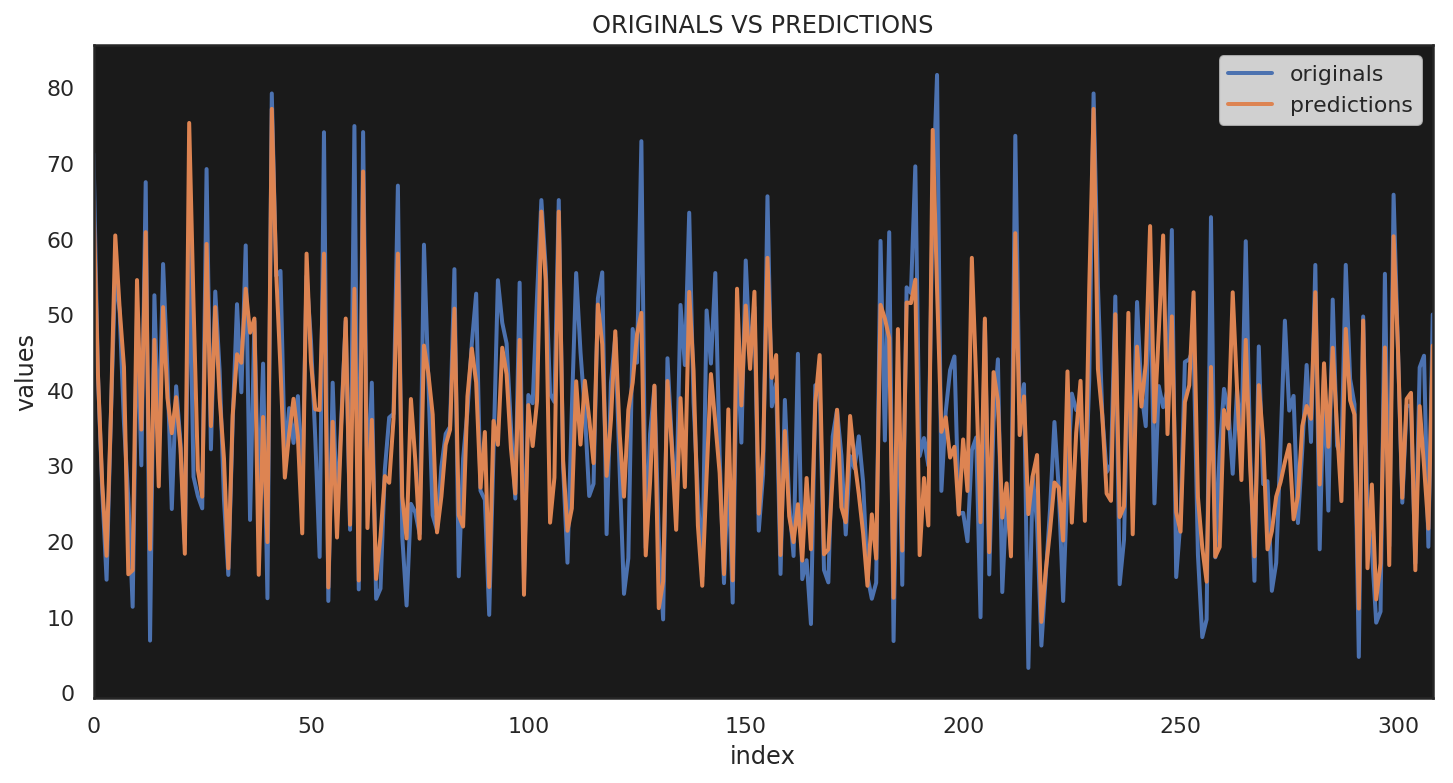

In [34]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(train_X,train_Y)

predictions = knn.predict(test_X)
predictions = pd.DataFrame(predictions)

test_y_new = test_Y.reset_index()
test_y_new = test_y_new["strength"]


ax3 = test_y_new.plot(label="originals",figsize=(12,6),linewidth=2)
ax3 = predictions[0].plot(label="predictions",figsize=(12,6),linewidth=2)
plt.legend(loc="best")
plt.title("ORIGINALS VS PREDICTIONS")
plt.xlabel("index")
plt.ylabel("values")
ax3.set_facecolor("k")

print (knn)
print ("************************************************************************")
print ("ROOT MEAN SQUARED ERROR : ",np.sqrt(mean_squared_error(test_Y,predictions)))
cross_valid = cross_val_score(knn,train_X,train_Y,cv=20,scoring="neg_mean_squared_error")
cross_valid = cross_valid.ravel()
print ("************************************************************************")
print ("CROSS VALIDATION SCORE")
print ("************************")
print ("cv-mean :",cross_valid.mean())
print ("cv-std  :",cross_valid.std())
print ("cv-max  :",cross_valid.max())
print ("cv-min  :",cross_valid.min())


Looking at the CV scores it looks like this model has served us better than the linear regression ones.


Now lets use decision tree regressors.

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
***************************************************************************
ROOT MEAN SQUARED ERROR : 6.463354342193441
***************************************************************************
CROSS VALIDATION SCORE
************************
cv-mean : -46.723702050905075
cv-std  : 21.214478589249833
cv-max  : -23.090078472222228
cv-min  : -109.48103333333333


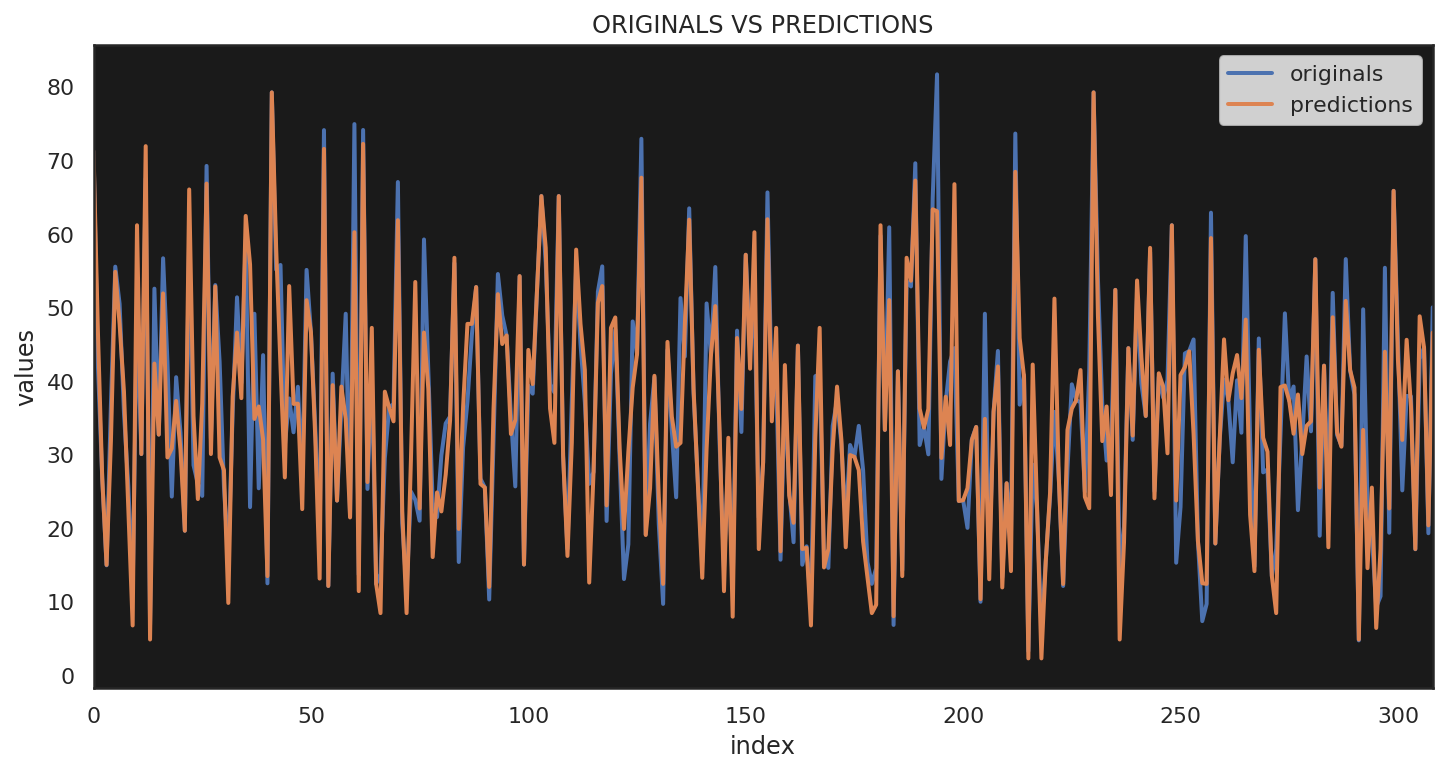

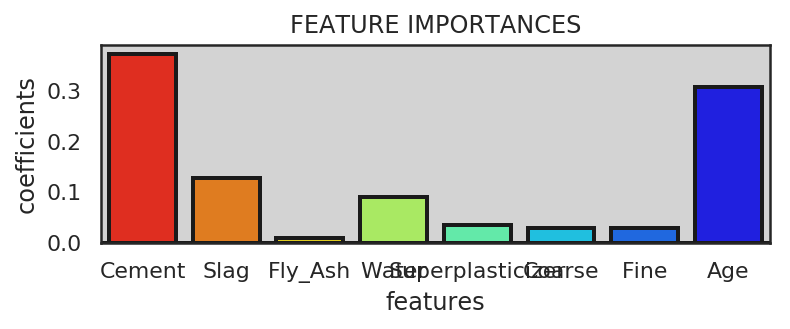

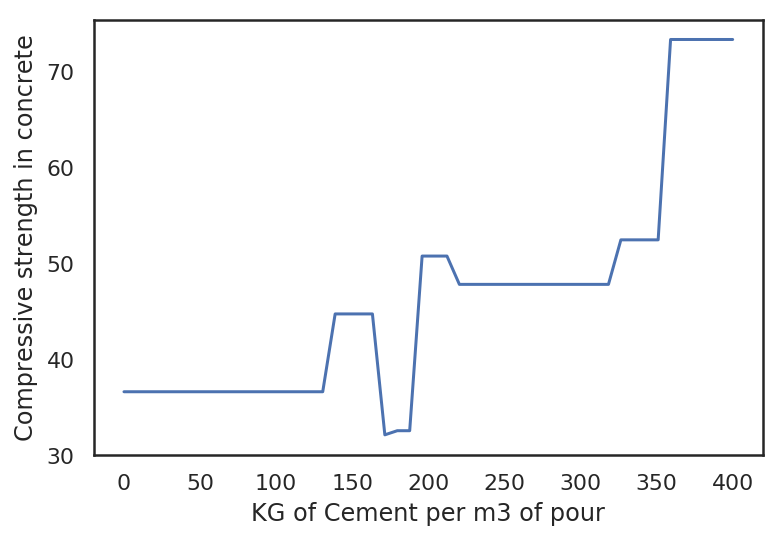

In [35]:


from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
model(dtr,train_X,train_Y,test_X,test_Y,df2,df2res,"feat")



The CV scores and the performance chart indicates that this might be the best model to use with our data. The fact that cement and age are the most important variables also agrees with traditional cement logic. The graph showing the variation between the amount of cement used and the compressive strength of the concrete looks weird for some reason. The effects below 200Kg can be explained by the fact that those points are outliers and very few cases of that exist.




### Misc analysis


Random stuff that I have done, that I did not find useful.

In [36]:

df2 = pd.DataFrame()

df2['Slag']=np.linspace(0, 400)
df2['Age'] = 360
df2['Fly_Ash']=55
df2['Water']=192
df2['Coarse'] = 970
df2['Fine']=825
df2['Superplasticizer']=0
df2['Cement']=198
df2['empty']=0


predictions =algorithm.predict(df2)
plt.plot(df2['Slag'], d)

plt.xlabel('KG of Slag per m3 of pour')
plt.ylabel('Compressive strength in concrete')
plt.legend();
df2.head()


NameError: name 'algorithm' is not defined

In [ ]:
df2res.head

In [ ]:

df3 = pd.DataFrame()
df3['Age'] = np.linspace(0, 50)
df3['Fly_Ash']=55
df3['Water']=180
df3['Cement']=280
df3['empty']=0
df3['Coarse'] = 970
df3['Fine']=780
df3['Superplasticizer']=6
df3['Slag']=70


predictions = NN_model.predict(df3)
plt.plot(df3['Age'], predictions)

plt.xlabel(' Age since pour')
plt.ylabel('Compressive strength in concrete')
plt.legend();
df3.head()

Lets examine the average error

In [ ]:
predictions = NN_model.predict(test)

i=0
avg=0
while i < len(predictions):
    mse=(test.iat[i,8]-predictions[i])**2
    #print(predictions[i])
    avg=avg+mse
    i=i+1
print(avg/i)
print((avg/i)/df.strength.mean()*100)
print ("% of error. The avg error divided by the average strength")
